<a href="https://colab.research.google.com/github/AbdelRayan/AutomaticSleepScoring/blob/main/Faranak/Faranak_Copy_of_SO_NREM_Substages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# install and import required libraries


In [1]:
%%capture
!pip install neurodsp
!pip install emd
!pip install tslearn
!pip install dtaidistance
!pip install sails

In [2]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import copy
import sails
import requests
from io import BytesIO

# Loading the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# # Loading sleep scoring data from MAT files stored in Google Drive.
path_to_pt5 = '/content/drive/My Drive/Donders /Datasets/2020-04-21_15-00-06_Post_Trial5'

In [5]:
pfc_cleaned = loadmat(path_to_pt5 + '/PFC_Cleaned.mat')
pfc_cleaned = pfc_cleaned['PFC_Cleaned']
pfc_cleaned = pfc_cleaned.reshape(-1, 1)
pfc_cleaned = pfc_cleaned[8*1000:]

In [6]:
#sleep_scoring = loadmat(path_to_pt5 + '/2020-04-21_15-00-06_Post_Trial5-states.mat')
#sleep_scoring = sleep_scoring['states']
#sleep_scoring = sleep_scoring[0, 7:]

In [7]:
pfc_data = pfc_cleaned.flatten()

In [8]:
len(pfc_data)

10785884

## RGS14

In [9]:
# # link to DropBox: https://www.dropbox.com/scl/fo/43ygu24t4pwwpvrgaimdj/h/3/Study_day_3_HC/post_trial5_2017-11-15_14-04-39?dl=0&subfolder_nav_tracking=1
# #

# url_pfc_RGS14 = "https://www.dropbox.com/scl/fo/43ygu24t4pwwpvrgaimdj/h/3/Study_day_3_HC/post_trial5_2017-11-15_14-04-39/PFC_100_CH49.continuous.mat?rlkey=5n19vud9g3fcleaehkfgmvjyn&dl=1"

url_pfc_RGS14 = 'https://www.dropbox.com/scl/fo/43ygu24t4pwwpvrgaimdj/h/13/2019-05-15_SD2_HC_Rat13_344994/2019-05-15_14-08-14_Post-Trial5/PFC_100_CH63_0.continuous.mat?rlkey=5n19vud9g3fcleaehkfgmvjyn&dl=1'

response_RGS14 = requests.get(url_pfc_RGS14)
response_RGS14.raise_for_status()

In [10]:
#state_response_url_RGS14 = 'https://www.dropbox.com/scl/fo/43ygu24t4pwwpvrgaimdj/h/3/Study_day_3_HC/post_trial5_2017-11-15_14-04-39/post_trial5_2017-11-15_14-04-39-states.mat?rlkey=5n19vud9g3fcleaehkfgmvjyn&dl=1'
state_respomse_url_RGS14 = 'https://www.dropbox.com/scl/fo/43ygu24t4pwwpvrgaimdj/h/13/2019-05-15_SD2_HC_Rat13_344994/2019-05-15_14-08-14_Post-Trial5/2019-05-15_14-08-14_Post-Trial5-states.mat?rlkey=5n19vud9g3fcleaehkfgmvjyn&dl=1'
state_response_RGS14 = requests.get(state_respomse_url_RGS14)
state_response_RGS14.raise_for_status()

In [11]:
PFC_100_CH49_RGS = scipy.io.loadmat(BytesIO(response_RGS14.content))

In [12]:
posttrial5_states_ES2_RGS = scipy.io.loadmat(BytesIO(state_response_RGS14.content))

In [13]:
lfp_RGS14 = np.squeeze(PFC_100_CH49_RGS['PFC'])
states_RGS14 = np.squeeze(posttrial5_states_ES2_RGS['states'])

In [14]:
for idx in range(len(states_RGS14)):
  if states_RGS14[idx] == 0:
    print(idx)

10794
10795
10796
10797
10798
10799
10800
10801
10802
10803
10804


In [15]:
lfp_RGS14 = lfp_RGS14[7*2500:-11*2500]
states_RGS14 = states_RGS14[:-11]

In [16]:
for idx in range(len(states_RGS14)):
  if states_RGS14[idx] == 0:
    print(idx)

In [17]:
len(lfp_RGS14)//1000//60

179

In [18]:
len(states_RGS14)//60

179

## CBD

In [19]:
# link to DropBox: https://www.dropbox.com/scl/fo/vk9sq7tky0mr2z0saf96h/ABZvpB4wKf2N3EPT-CVimbU/3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD2_HC_20210603/2021-06-03_13-34-04_posttrial5?dl=0&rlkey=j12mjuudr49jcb18c68rzxe24&subfolder_nav_tracking=1
#

url_pfc_CBD = "https://www.dropbox.com/scl/fo/vk9sq7tky0mr2z0saf96h/ALbOaCWN4JJJ-3Vr_XBthTs/3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD2_HC_20210603/2021-06-03_13-34-04_posttrial5/PFC_100_CH22_0.continuous.mat?rlkey=j12mjuudr49jcb18c68rzxe24&dl=1"

response_CBD = requests.get(url_pfc_CBD)
response_CBD.raise_for_status()

In [20]:
state_response_url_CBD = 'https://www.dropbox.com/scl/fo/vk9sq7tky0mr2z0saf96h/ABCU-y3YXyh9dBzp22RUaJw/3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD2_HC_20210603/2021-06-03_13-34-04_posttrial5/2021-06-03_13-34-04_posttrial5-states_ES2.mat?rlkey=j12mjuudr49jcb18c68rzxe24&dl=1'
state_response_CBD = requests.get(state_response_url_CBD)
state_response_CBD.raise_for_status()

In [21]:
PFC_100_CH22_CBD = scipy.io.loadmat(BytesIO(response_CBD.content))

In [22]:
posttrial5_states_ES2_CBD = scipy.io.loadmat(BytesIO(state_response_CBD.content))

In [23]:
lfp_CBD = np.squeeze(PFC_100_CH22_CBD['PFC'])
states_CBD = np.squeeze(posttrial5_states_ES2_CBD['states'])

In [24]:
len(lfp_CBD)/2500/60

180.0613

In [25]:
len(states_CBD)/60

180.05

## OS Basic

In [26]:
# link to DropBox: https://www.dropbox.com/scl/fo/dw1kw8acsna3qponvydwy/h/1/HC/post_trial5_2017-09-27_14-18-24?dl=0&subfolder_nav_tracking=1
#

#url_pfc_OSB = "https://www.dropbox.com/scl/fo/dw1kw8acsna3qponvydwy/h/1/HC/post_trial5_2017-09-27_14-18-24/PFC_100_CH11.continuous.mat?rlkey=hs1o7bequxipnl1m8eii7eibu&dl=1"
url_pfc_OSB = "https://www.dropbox.com/scl/fo/dw1kw8acsna3qponvydwy/h/6/Study_day6_HC_28feb2018/Post_trial5_2018-02-28_13-42-34/PFC_100_CH33.continuous.mat?rlkey=hs1o7bequxipnl1m8eii7eibu&dl=1"
response_OSB = requests.get(url_pfc_OSB)
response_OSB.raise_for_status()

In [27]:
#state_response_url_OSB = 'https://www.dropbox.com/scl/fo/dw1kw8acsna3qponvydwy/h/1/HC/post_trial5_2017-09-27_14-18-24/post_trial5_2017-09-27_14-18-24-states.mat?rlkey=hs1o7bequxipnl1m8eii7eibu&dl=1'
state_response_url_OSB = 'https://www.dropbox.com/scl/fo/dw1kw8acsna3qponvydwy/h/6/Study_day6_HC_28feb2018/Post_trial5_2018-02-28_13-42-34/post_trial5_2018-02-28_13-42-34-states.mat?rlkey=hs1o7bequxipnl1m8eii7eibu&dl=1'
state_response_OSB = requests.get(state_response_url_OSB)
state_response_OSB.raise_for_status()

In [28]:
PFC_100_CH11_OSB = scipy.io.loadmat(BytesIO(response_OSB.content))

In [29]:
posttrial5_states_ES2_OSB = scipy.io.loadmat(BytesIO(state_response_OSB.content))

In [30]:
lfp_OSB = np.squeeze(PFC_100_CH11_OSB['PFC'])
states_OSB = np.squeeze(posttrial5_states_ES2_OSB['states'])

In [31]:
for idx in range(len(states_OSB)):
  if states_OSB[idx] == 0:
    print(idx)

0
1
2
3
4
10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
10799


In [32]:
lfp_OSB = lfp_OSB[7*2500:-11*2500]
states_OSB = states_OSB[7:-11]

In [33]:
for idx in range(len(states_OSB)):
  if states_OSB[idx] == 0:
    print(idx)

In [34]:
len(states_OSB)/60

179.7

In [35]:
len(lfp_OSB)/2500/60

179.70981333333333

In [36]:
len(states_OSB)/60

179.7

# RGS

In [37]:
def find_all_NREM_epochs(arr):
    nrem_epochs = []
    start_index = None

    for i, num in enumerate(arr):
        if num == 3:
            if start_index is None:
                start_index = i
        elif num != 3 and start_index is not None:
            nrem_epochs.append([start_index, i - 1])
            start_index = None

    if start_index is not None:
        nrem_epochs.append([start_index, len(arr) - 1])

    return nrem_epochs

In [38]:
def peak_before_trough(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return arr[i]
  return -1

def peak_before_trough_pos(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return i
  return -1

def peak_to_trough_duration(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 20, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return trough_pos-i
  return -1

def num_inflection_points(arr):
  sign_changes = np.diff(np.sign(np.diff(arr, 2)))
  num_inflection_points = np.sum(sign_changes != 0)
  return num_inflection_points

def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

# Compute metrics for each cycle -
def get_cycles_with_metrics(cycles, data, IA, IF, conditions=None):
  C = copy.deepcopy(cycles)

  C.compute_cycle_metric('duration_samples', data, func=len)
  C.compute_cycle_metric('peak2trough', data, func=peak2trough)
  C.compute_cycle_metric('asc2desc', data, func=asc2desc)
  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('trough_values', data, func=np.min)
  C.compute_cycle_metric('peak_values', data, func=np.max)
  C.compute_cycle_metric('mean_if', IF, func=np.mean)
  C.compute_cycle_metric('max_if', IF, func=np.max)
  C.compute_cycle_metric('range_if', IF, func=compute_range)

  C.compute_cycle_metric('trough_position', data, func=np.argmin)
  C.compute_cycle_metric('peak_position', data, func=np.argmax)
  return C

In [39]:
nrem_epochs = find_all_NREM_epochs(states_RGS14)

In [40]:
nrem_epochs

[[1560, 1570],
 [1587, 1599],
 [1611, 1667],
 [1682, 1735],
 [1743, 1748],
 [1760, 1776],
 [2041, 2050],
 [2063, 2123],
 [2143, 2160],
 [2175, 2340],
 [2587, 2863],
 [2898, 2936],
 [3016, 3259],
 [5767, 5781],
 [5790, 5839],
 [5905, 6202],
 [6446, 6773],
 [6848, 7228],
 [7277, 7432],
 [7571, 7669],
 [7707, 7946],
 [8052, 8240],
 [8252, 8307],
 [8366, 8551],
 [8733, 8774],
 [8791, 8947],
 [8964, 9049],
 [9062, 9122]]

In [41]:
a = np.diff(nrem_epochs)

In [42]:
b = a[:, 0]

In [43]:
sum(b)

3289

In [44]:
len(lfp_RGS14)/1000/60

179.3534

In [45]:
# Joining all the NREM epochs and filtering the Delta band

fs = 1000 # Sampling rate/frequency
nrem_data_RGS = []
for start, end in nrem_epochs:
  pfc_data_part_RGS = lfp_RGS14[start*fs:end*fs]
  nrem_data_RGS.extend(pfc_data_part_RGS)
nrem_data_RGS = np.array(nrem_data_RGS)

In [46]:
# cut_off = 20
# fs = 1000

# n_cycles = 5

# low_sig, filter_coefs = filter_signal_fir(
#     sig=nrem_data,
#     fs=fs,
#     pass_type='lowpass',
#     f_range=cut_off,
#     n_cycles=n_cycles,
#     remove_edges=True,  #
#     print_transitions=True,
#     plot_properties=True,  #
#     return_filter=True
# )

In [47]:
fs

1000

Transition bandwidth is 0.2 Hz.
Pass/stop bandwidth is 3.9 Hz.


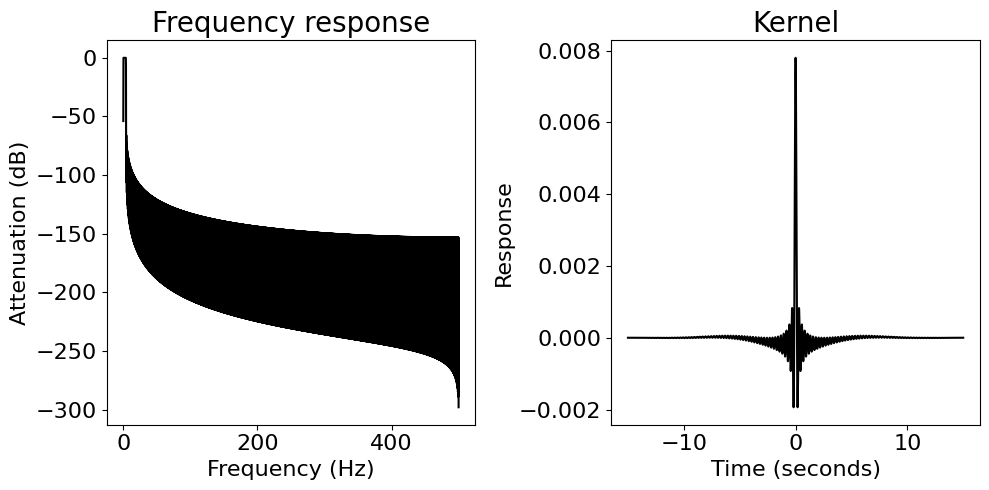

In [48]:
#nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
nrem_filtered_data = filter_signal_fir(nrem_data_RGS, fs,
                                       'bandpass', (0.1, 4),
                                       n_cycles=3, remove_edges=False,
                                       print_transitions=True, plot_properties=True)
# For testing, subset data
# nrem_filtered_data = nrem_filtered_data[:fs*60*10]

In [49]:
# Extract Instantaneous phase (IP), frequency and amplitude (from Hilbert Transform)
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, fs, 'hilbert')

# Get cycles using IP
C = emd.cycles.Cycles(IP)

 Checking Cycles inputs - trimming singleton from input 'IP'


In [50]:
cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)

In [51]:
def get_cycles_with_conditions(cycles, fs, conditions):
  C = copy.deepcopy(cycles)
  metrics = C.get_metric_dataframe()

  amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
  peak_thresh = np.percentile(metrics['peak_values'], 85)
  trough_thresh = np.percentile(metrics['trough_values'], 40)

  lo_freq_duration = fs/0.1
  hi_freq_duration = fs/4

  C.pick_cycle_subset(conditions)
  return C

In [52]:
metrics = cycles.get_metric_dataframe()
amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
peak_thresh = np.percentile(metrics['peak_values'], 85)
trough_thresh = np.percentile(metrics['trough_values'], 40)
lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [53]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
all_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [54]:
all_metrics = all_cycles.get_metric_dataframe(subset=True)
all_metrics

,index,is_good,duration_samples,peak2trough,asc2desc,max_amp,trough_values,peak_values,mean_if,max_if,range_if,trough_position,peak_position,chain_ind
0,15,1,357,0.397549,0.546282,182.416615,-174.255212,106.039290,2.804296,6.083821,3.956778,236,74,0
1,18,1,447,0.478219,0.491336,166.260871,-147.749236,77.061599,2.234176,2.408013,0.304437,344,116,1
2,21,1,510,0.549654,0.598505,163.232208,-161.878714,73.902992,1.961430,2.219391,0.735290,397,192,2
3,25,1,570,0.565318,0.658653,165.688625,-156.479825,122.630982,1.754773,2.276046,1.889828,425,231,3
4,30,1,363,0.529425,0.552585,183.922169,-171.664866,150.318165,2.756476,3.187460,0.727706,275,113,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,8414,1,645,0.415113,0.690801,671.711992,-413.286393,634.696140,1.550829,2.105119,1.618311,359,159,1569
2483,8417,1,480,0.617234,0.362249,290.733389,-198.265017,131.636510,2.085659,3.372970,2.563292,401,95,1570
2484,8419,1,326,0.601522,0.525958,408.766850,-226.820228,408.624029,3.066319,4.324591,1.962277,259,105,1571
2485,8422,1,375,0.611088,0.534802,552.106424,-214.176339,526.412307,2.663137,7.256086,5.214911,295,120,1572


## Get SO and delta cycles

In [55]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
so_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [56]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
delta_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [57]:
metrics_so = so_cycles.get_metric_dataframe(subset=True)
metrics_delta = delta_cycles.get_metric_dataframe(subset=True)

## Rate of SO and delta cycles

In [58]:
def get_masked_cycles(IP, cycles):
  mask = np.full(cycles.nsamples, False)
  subset_cycles = cycles.get_metric_dataframe(subset=True)['index']

  for i in subset_cycles:
    inds = cycles.get_inds_of_cycle(i)
    mask[inds] = True

  masked_so_cycles = emd.cycles.get_cycle_vector(IP, mask=mask)
  return masked_so_cycles

In [59]:
def rate_cycle(cycles_vector, duration=1, fs=1000):
  samples_per_segment = duration * fs
  segments = np.array_split(cycles_vector, np.arange(samples_per_segment, len(cycles_vector), samples_per_segment))
  segments = np.array(segments[:-1])

  rate = []
  for segment in segments:
    if -1 in segment:
      rate.append(len(np.unique(segment))-1)
    else:
      rate.append(len(np.unique(segment)))
  rate = np.array(rate)
  rate = rate/duration
  return rate, segments

In [60]:
so_cycles_vector = get_masked_cycles(IP, so_cycles)
delta_cycles_vector = get_masked_cycles(IP, delta_cycles)

## 3s window

In [61]:
so_cycles_rate, _ = rate_cycle(so_cycles_vector, duration=3, fs=1000)
delta_cycles_rate, _ = rate_cycle(delta_cycles_vector, duration=3, fs=1000)

Text(0.5, 0, 'Time (3 sec windows)')

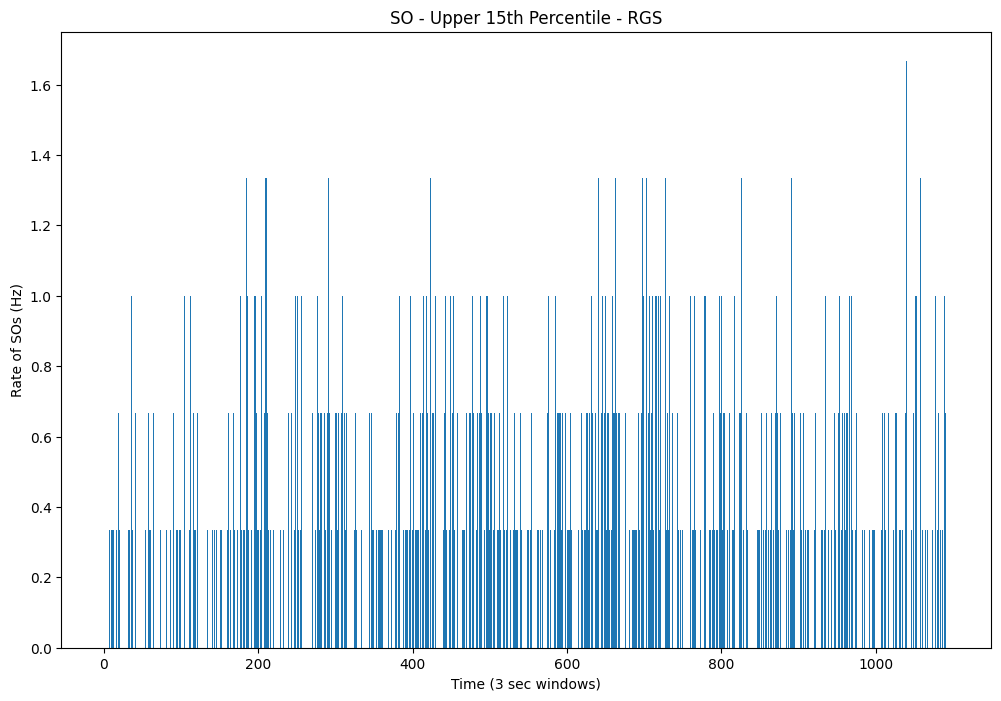

In [62]:
plt.figure(figsize=(12,8))

plt.title('SO - Upper 15th Percentile - RGS')
plt.bar(range(len(so_cycles_rate)), so_cycles_rate)
plt.ylabel("Rate of SOs (Hz)")
plt.xlabel("Time (3 sec windows)")

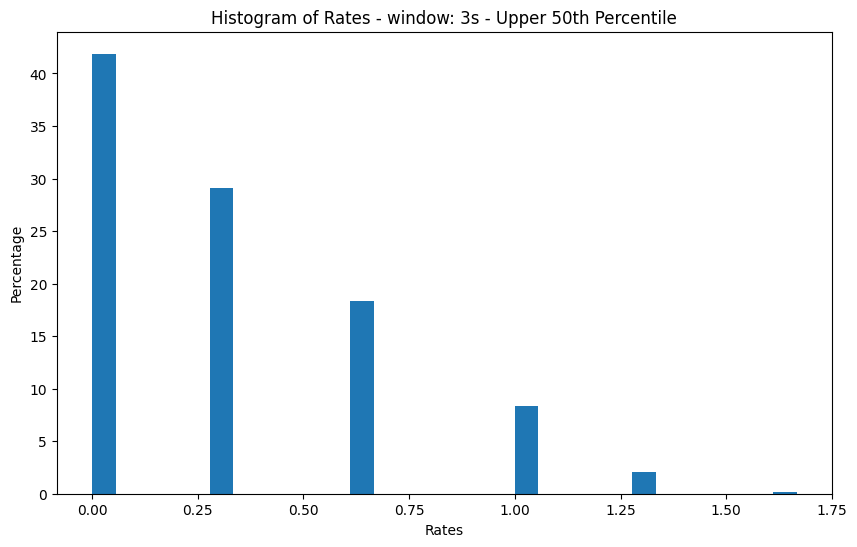

In [63]:
plt.figure(figsize=(10, 6))
weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)
plt.hist(so_cycles_rate, bins=30, weights=weights)
plt.xlabel('Rates')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - window: 3s - Upper 50th Percentile')
plt.show()

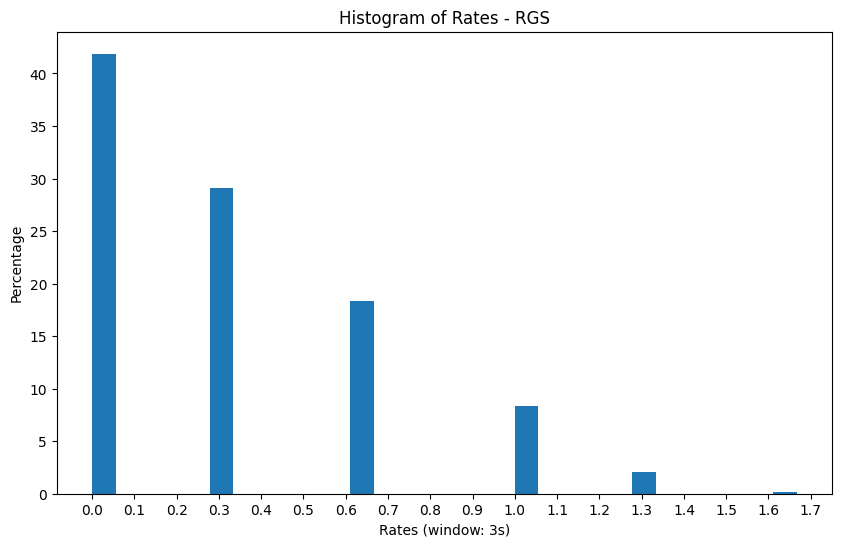

In [64]:
plt.figure(figsize=(10, 6))

weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)

plt.hist(so_cycles_rate, bins=30, weights=weights)

min_x = min(so_cycles_rate)
max_x = max(so_cycles_rate)
x_ticks = np.arange(min_x, max_x + 0.1, 0.1)
plt.xticks(x_ticks)

plt.xlabel('Rates (window: 3s)')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - RGS')
plt.show()

In [65]:
def score_rates(so_cycles_rate):

  score_array = np.zeros_like(so_cycles_rate)
  for idx in range(len(so_cycles_rate)):
    if so_cycles_rate[idx] < 0.2:
      score_array[idx] = 1
    elif so_cycles_rate[idx] <=0.8 and so_cycles_rate[idx]  >= 0.2:
      score_array[idx] = 2
    else:
      score_array[idx] = 3
  return score_array

In [66]:
score_array = score_rates(so_cycles_rate)

In [67]:
np.unique(score_array)

array([1., 2., 3.])

Text(0.5, 0, 'Time - window: 3s')

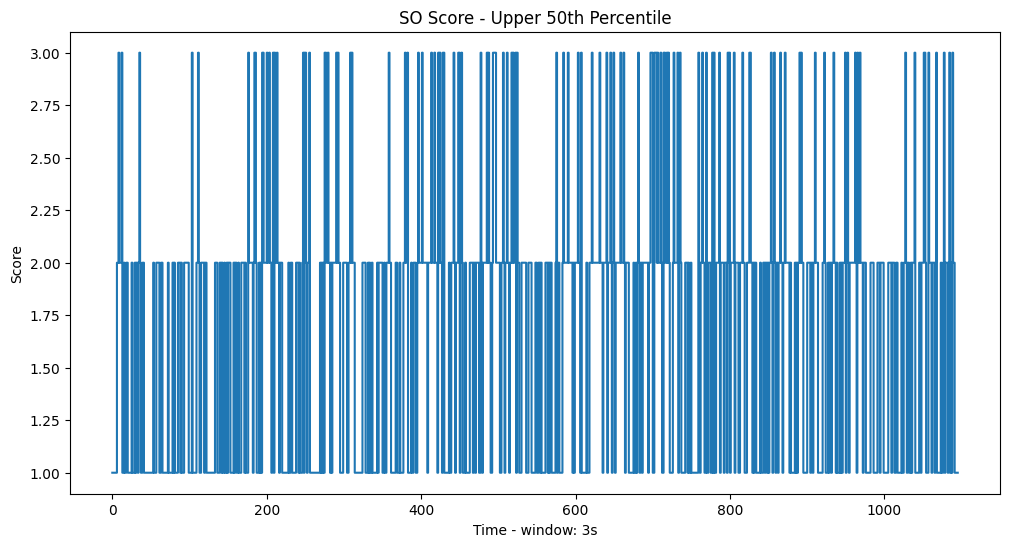

In [68]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score - Upper 50th Percentile')
plt.ylabel('Score')
plt.xlabel('Time - window: 3s')

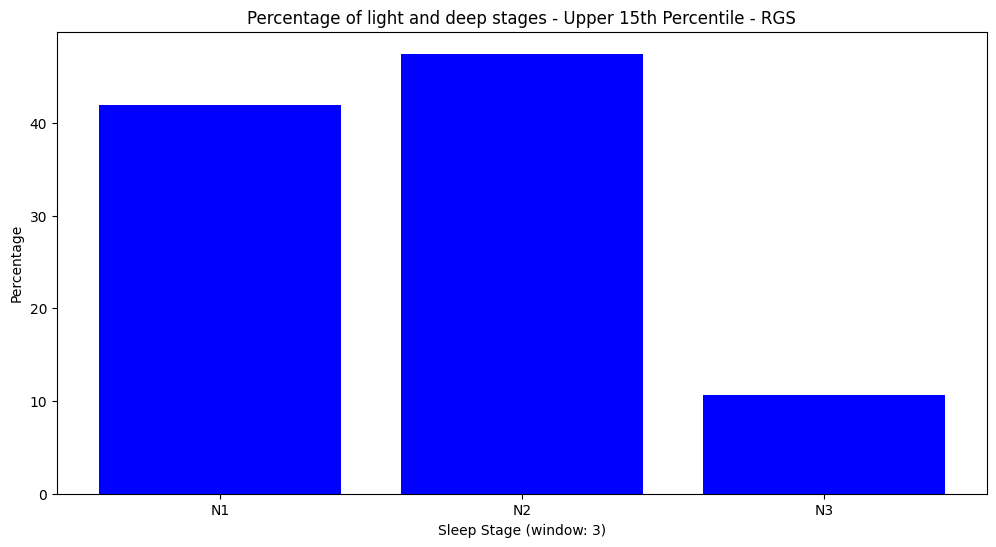

In [69]:
unique, counts = np.unique(score_array, return_counts=True)
percentages = counts / len(score_array) * 100

plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["N1", "N2", "N3"], color=['b', 'b', 'b'])
plt.xlabel('Sleep Stage (window: 3)')
plt.ylabel('Percentage')
titlee = 'Percentage of light and deep stages - Upper 15th Percentile - RGS'
plt.title(titlee)
plt.show()

### Criterias for merging

Text(0.5, 0, 'Time')

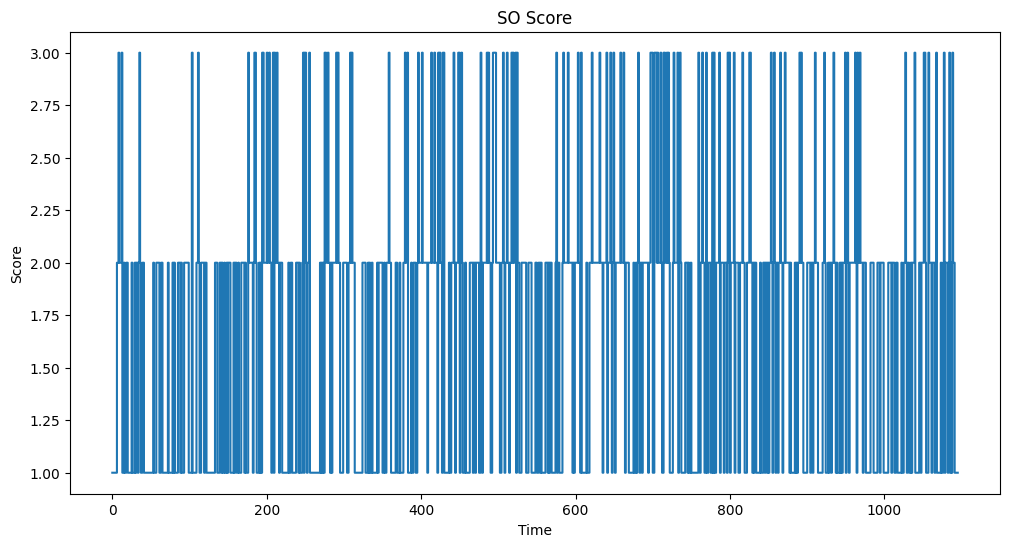

In [70]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score')
plt.ylabel('Score')
plt.xlabel('Time')

In [71]:
NREM_recunstruct = []

for score in score_array:
  for _ in range(3):
    NREM_recunstruct.append(score)
NREM_recunstruct.append(score_array[-1])

In [72]:
len(NREM_recunstruct)

3289

In [73]:
for i, score in enumerate(NREM_recunstruct):
    NREM_recunstruct[i] = score + 5

In [74]:
len(NREM_recunstruct)

3289

In [75]:
def make_new_scoring(sleep_scoring, new_nrem, nrem_epochs):
    sleep_array = np.array(sleep_scoring)
    i = 0
    for start, end in nrem_epochs:
        segment_length = end - start
        sleep_array[start:end] = new_nrem[i:i + segment_length]
        i += segment_length
    return sleep_array

In [76]:
final_scores = make_new_scoring(states_RGS14, NREM_recunstruct, nrem_epochs)

In [77]:
len(final_scores)

10794

In [78]:
for i in range(1, len(final_scores)):
  if final_scores[i] == 3:
    final_scores[i] = final_scores[i - 1]

In [79]:
for i, score in enumerate(final_scores):
  if score == 6:
    final_scores[i] = 2
  elif score == 7:
    final_scores[i] = 3
  elif score == 8:
    final_scores[i] = 4
  elif score == 4:
    final_scores[i] = 5
  elif score == 5:
    final_scores[i] = 6

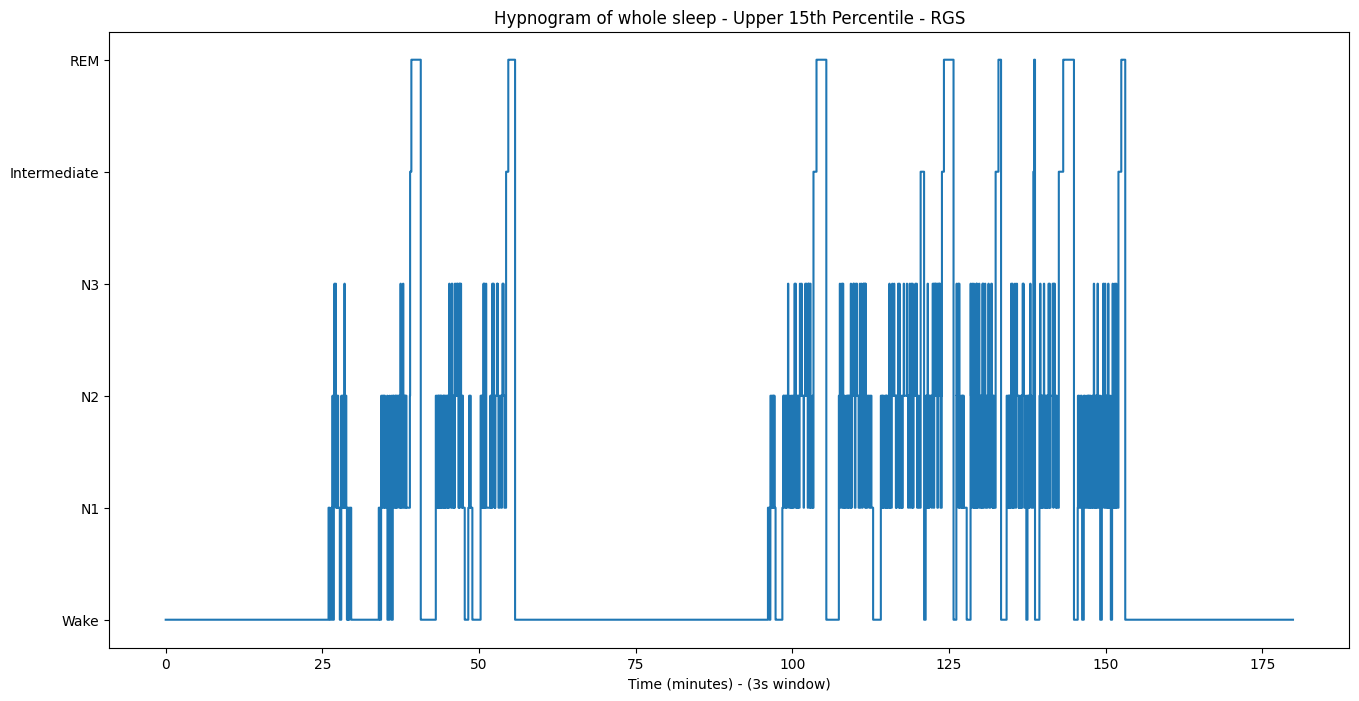

In [80]:
score_labels = {1: 'Wake', 2:'N1', 3:'N2', 4:'N3', 5: 'Intermediate', 6: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}
plt.figure(figsize=(16, 8))
time_minutes = np.arange(0, len(final_scores)) / 60
plt.step(time_minutes,final_scores)
plt.title('Hypnogram of whole sleep - Upper 15th Percentile - RGS')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xlabel("Time (minutes) - (3s window)")
plt.savefig('hypnogram_3s_15th.svg', format='svg')

In [81]:
unique, counts = np.unique(final_scores, return_counts=True)

In [82]:
unique

array([1, 2, 3, 4, 5, 6], dtype=uint8)

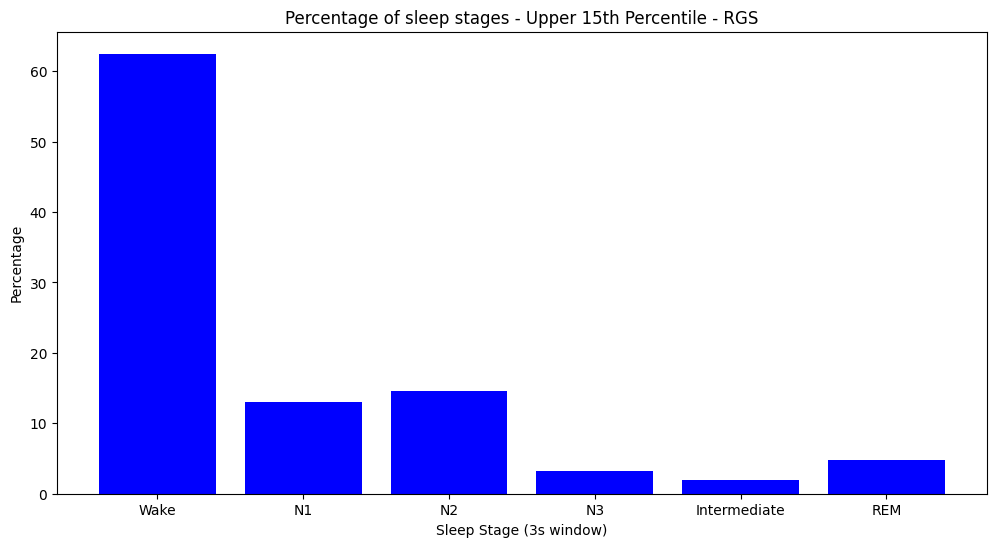

In [83]:
unique, counts = np.unique(final_scores, return_counts=True)
percentages = counts / len(final_scores) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["Wake", 'N1', 'N2', 'N3', 'Intermediate', 'REM'], color=['b', 'b', 'b', 'b', 'b', 'b'])
plt.xlabel('Sleep Stage (3s window)')
plt.ylabel('Percentage')
titlee = 'Percentage of sleep stages - Upper 15th Percentile - RGS'
plt.title(titlee)
plt.savefig('Percentage-3s-15th.svg', format='svg')
plt.show()

In [84]:
f_lowpass = 20
band = (0.1, 4)
n_cycles = 3
low_sig = filter_signal_fir(pfc_data, fs, 'lowpass', f_lowpass, n_cycles=n_cycles, remove_edges=False)
delta_signal = filter_signal_fir(low_sig, fs, 'bandpass', band, n_cycles=n_cycles, remove_edges=False)

In [85]:
np.unique(final_scores)

array([1, 2, 3, 4, 5, 6], dtype=uint8)

In [86]:
def upscale_score(score_array, fs=1000):
  scores = []
  for i in range(len(score_array)):
    for _ in range(fs):
      scores.append(score_array[i])
  return scores

In [87]:
def extract_n2_episodes(sleep_stages):
    sleep_stages = np.asarray(sleep_stages).flatten()
    n2_indices = np.where(sleep_stages == 3)[0]

    episodes = []
    if len(n2_indices) == 0:
        return episodes

    start_idx = None
    for i in range(len(n2_indices)):
        if start_idx is None:
            start_idx = n2_indices[i]
        if i == len(n2_indices) - 1 or n2_indices[i + 1] != n2_indices[i] + 1:
            end_idx = n2_indices[i]
            episodes.append((start_idx, end_idx))
            start_idx = None

    return episodes

In [88]:
def extract_n3_episodes(sleep_stages):
    sleep_stages = np.asarray(sleep_stages).flatten()
    n3_indices = np.where(sleep_stages == 4)[0]

    episodes = []
    if len(n3_indices) == 0:
        return episodes

    start_idx = None
    for i in range(len(n3_indices)):
        if start_idx is None:
            start_idx = n3_indices[i]
        if i == len(n3_indices) - 1 or n3_indices[i + 1] != n3_indices[i] + 1:
            end_idx = n3_indices[i]
            episodes.append((start_idx, end_idx))
            start_idx = None

    return episodes

9062   9122
3


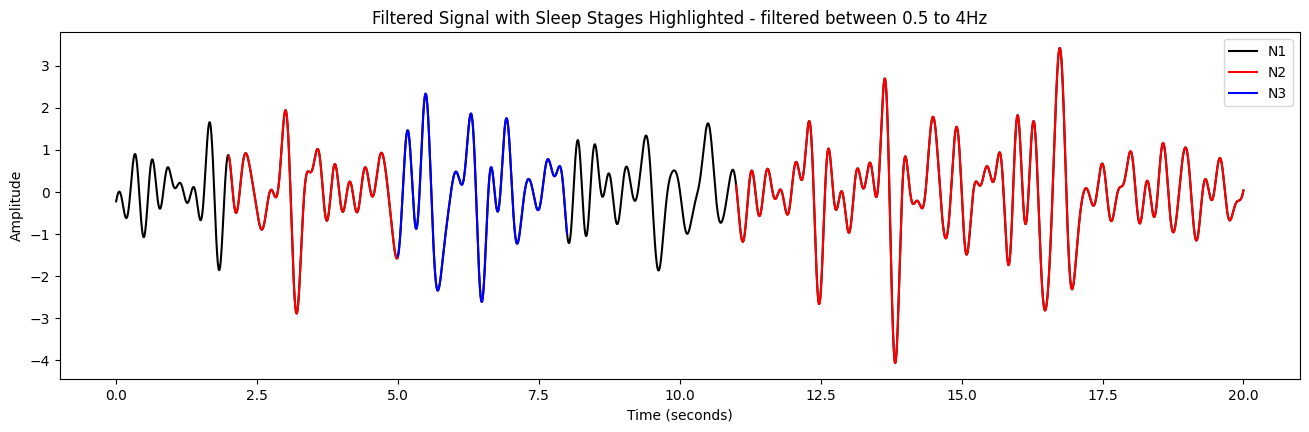

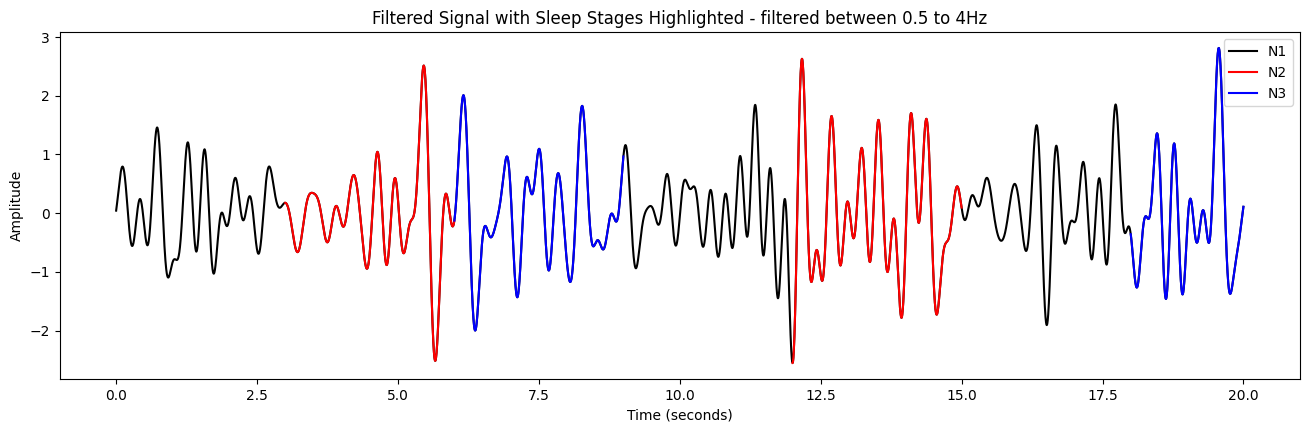

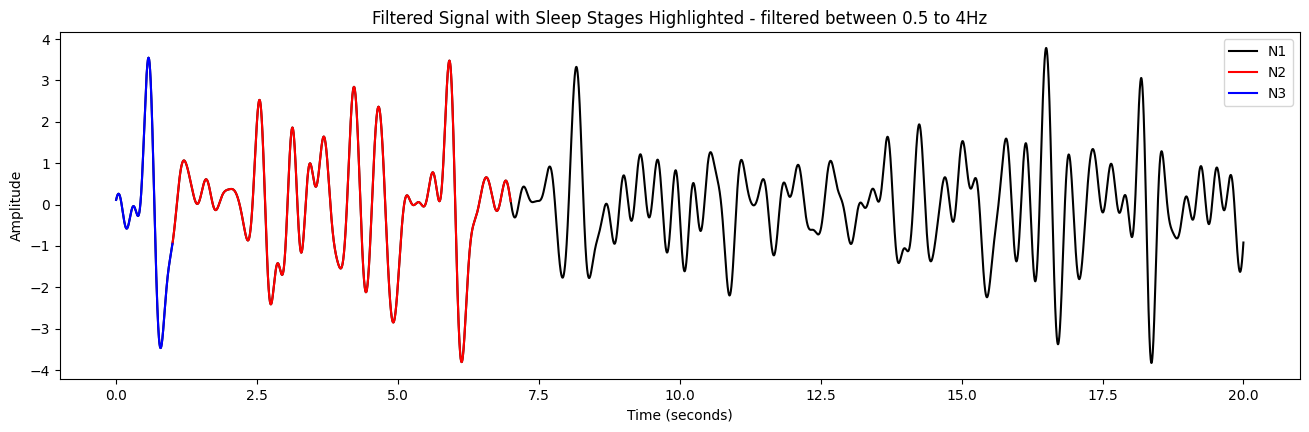

In [89]:
nrem_signal_segment = delta_signal[start*fs: end*fs]
score_segment = final_scores[start:end]
upscaled_scores = upscale_score(score_segment, fs=1000)

batch_length = 20

total_batches = int(np.ceil(len(nrem_signal_segment) / (batch_length * fs)))
print(start, ' ', end)
print(total_batches)
for i in range(total_batches):
    batch_start_idx = i * batch_length * fs
    batch_end_idx = min((i + 1) * batch_length * fs, len(nrem_signal_segment))

    twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
    twenty_sec_stages = upscaled_scores[batch_start_idx:batch_end_idx]

    n2_episodes = extract_n2_episodes(twenty_sec_stages)
    n3_episodes = extract_n3_episodes(twenty_sec_stages)

    t = np.arange(0, len(twenty_sec_sig) / fs, 1/fs)

    plt.figure(figsize=(16, 4.5))

    plt.plot(t, twenty_sec_sig, color='black', label='N1')

    for start_idx, end_idx in n2_episodes:
        plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

    for start_idx, end_idx in n3_episodes:
        plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Filtered Signal with Sleep Stages Highlighted - filtered between 0.5 to 4Hz')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

In [90]:
def plot_nrem(signal, scores, start, end, batch_length, fs=1000):

    nrem_signal_segment = signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    # Calculate total number of batches
    total_batches = int(np.ceil(len(nrem_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):
        # Determine batch start and end indices
        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(nrem_signal_segment))

        # Extract the signal and stages for the current batch
        twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
        twenty_sec_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        # Extract N2 and N3 episodes
        n2_episodes = extract_n2_episodes(twenty_sec_stages)
        n3_episodes = extract_n3_episodes(twenty_sec_stages)
        print(n2_episodes)
        print(n3_episodes)
        # Generate time array dynamically based on the actual length of the segment
        t = np.arange(0, len(twenty_sec_sig) / fs, 1/fs)

        # Plot the signal with sleep stages highlighted
        plt.figure(figsize=(16, 4.5))
        plt.plot(t, twenty_sec_sig, color='black', label='N1')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1}')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()

Start: 9062, End: 9122
Total Batches: 3
[(2000, 4999), (11000, 19999)]
[(5000, 7999)]


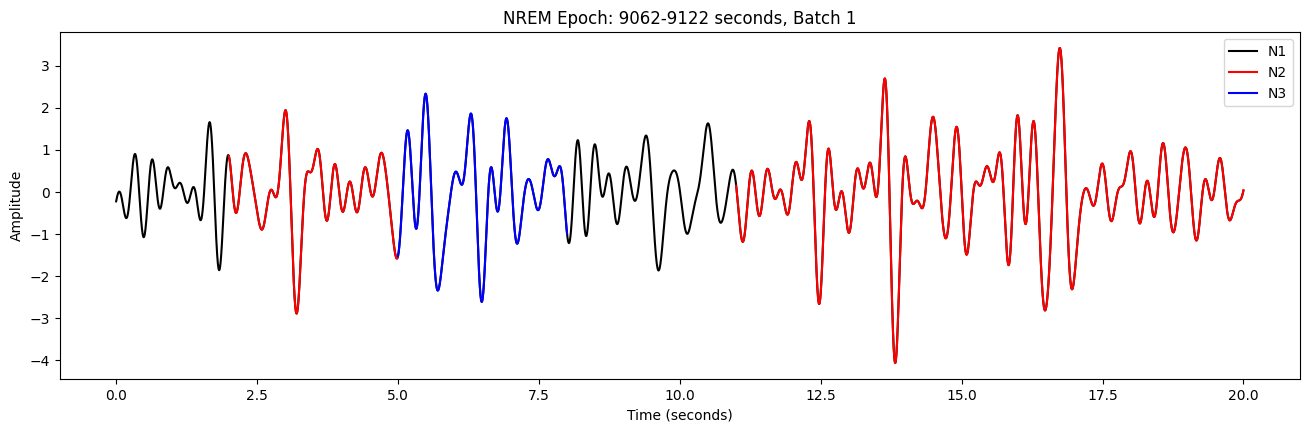

[(3000, 5999), (12000, 14999)]
[(6000, 8999), (18000, 19999)]


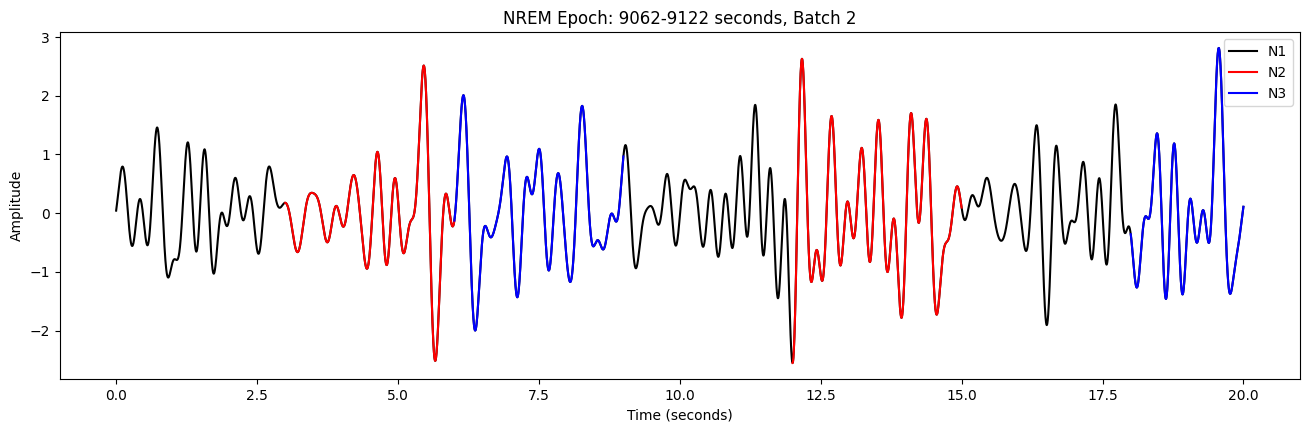

[(1000, 6999)]
[(0, 999)]


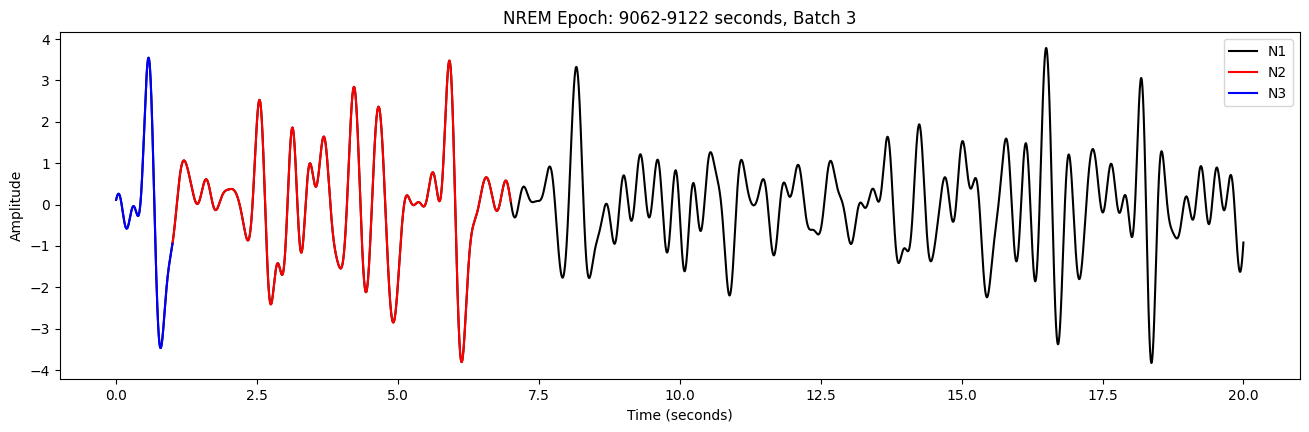

In [91]:
plot_nrem(delta_signal, final_scores, start, end, batch_length=20, fs=1000)

In [92]:
def plot_nrem2(filtered_signal, raw_signal, scores, start, end, batch_length, fs=1000):

    filtered_signal_segment = filtered_signal[start * fs: end * fs]
    raw_signal_segment = raw_signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    total_batches = int(np.ceil(len(filtered_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):

        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(filtered_signal_segment))

        filtered_batch_sig = filtered_signal_segment[batch_start_idx:batch_end_idx]
        raw_batch_sig = raw_signal_segment[batch_start_idx:batch_end_idx]
        batch_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        n2_episodes = extract_n2_episodes(batch_stages)
        n3_episodes = extract_n3_episodes(batch_stages)

        t = np.arange(0, len(filtered_batch_sig) / fs, 1/fs)

        plt.figure(figsize=(16, 9))

        plt.subplot(2, 1, 1)
        plt.plot(t, filtered_batch_sig, color='black', label='N1 (Filtered)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Filtered)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Filtered)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Filtered)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.subplot(2, 1, 2)
        plt.plot(t, raw_batch_sig, color='black', label='N1 (Raw)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Raw)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Raw)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.savefig(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)-3s-15th.svg', format='svg')
        plt.show()

In [93]:
nrem_epochs

[[1560, 1570],
 [1587, 1599],
 [1611, 1667],
 [1682, 1735],
 [1743, 1748],
 [1760, 1776],
 [2041, 2050],
 [2063, 2123],
 [2143, 2160],
 [2175, 2340],
 [2587, 2863],
 [2898, 2936],
 [3016, 3259],
 [5767, 5781],
 [5790, 5839],
 [5905, 6202],
 [6446, 6773],
 [6848, 7228],
 [7277, 7432],
 [7571, 7669],
 [7707, 7946],
 [8052, 8240],
 [8252, 8307],
 [8366, 8551],
 [8733, 8774],
 [8791, 8947],
 [8964, 9049],
 [9062, 9122]]

In [94]:
start, end = nrem_epochs[27]
print(start, end)
print((end - start + 1)/27)

9062 9122
2.259259259259259


Start: 9062, End: 9122
Total Batches: 2


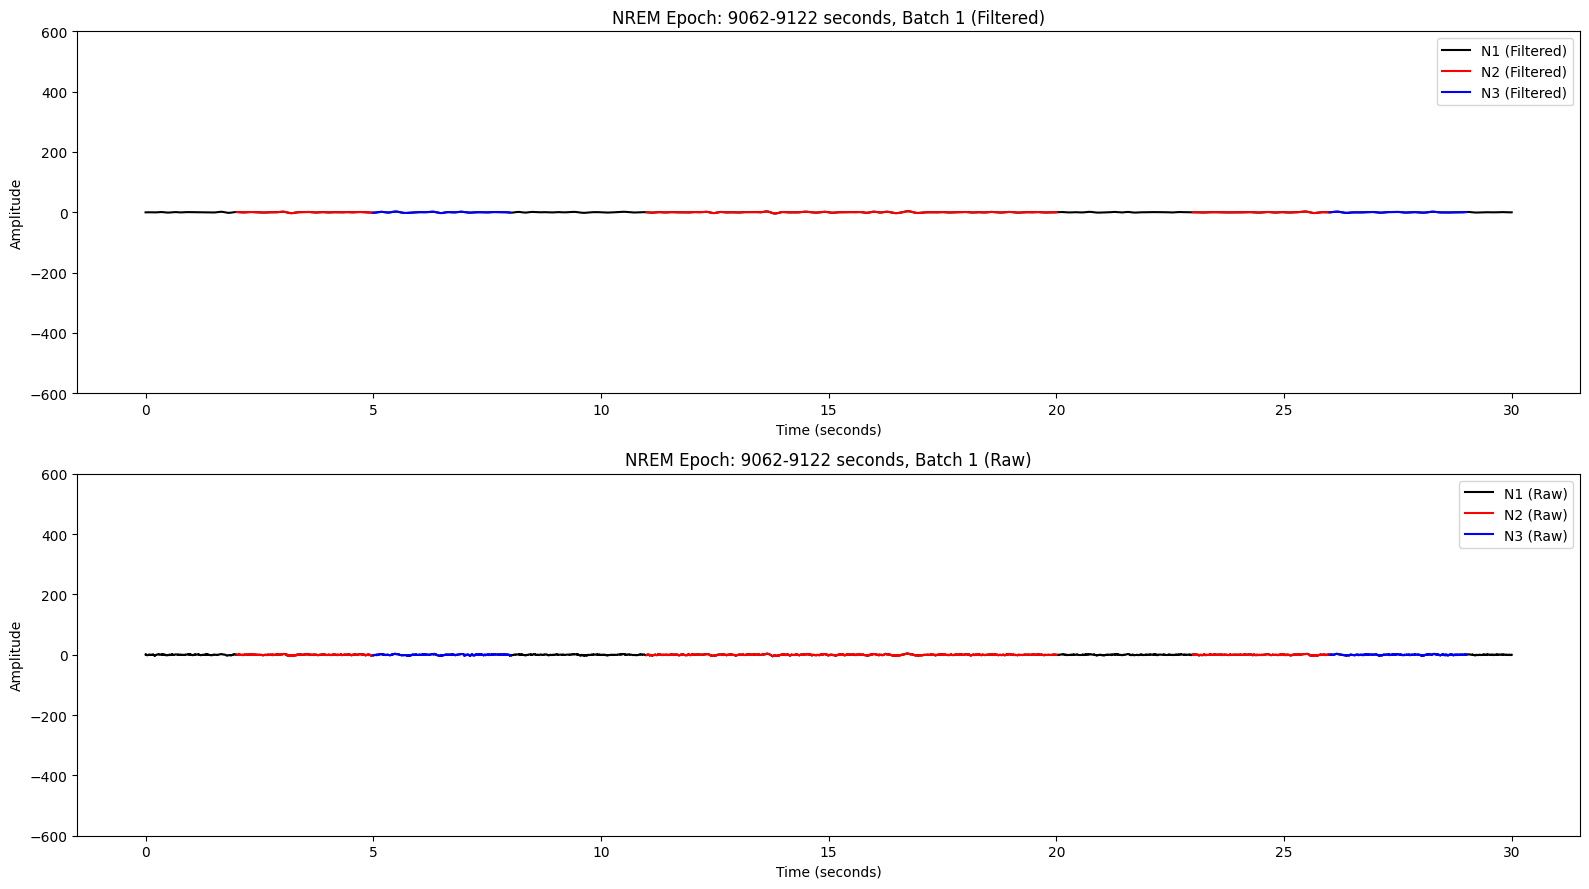

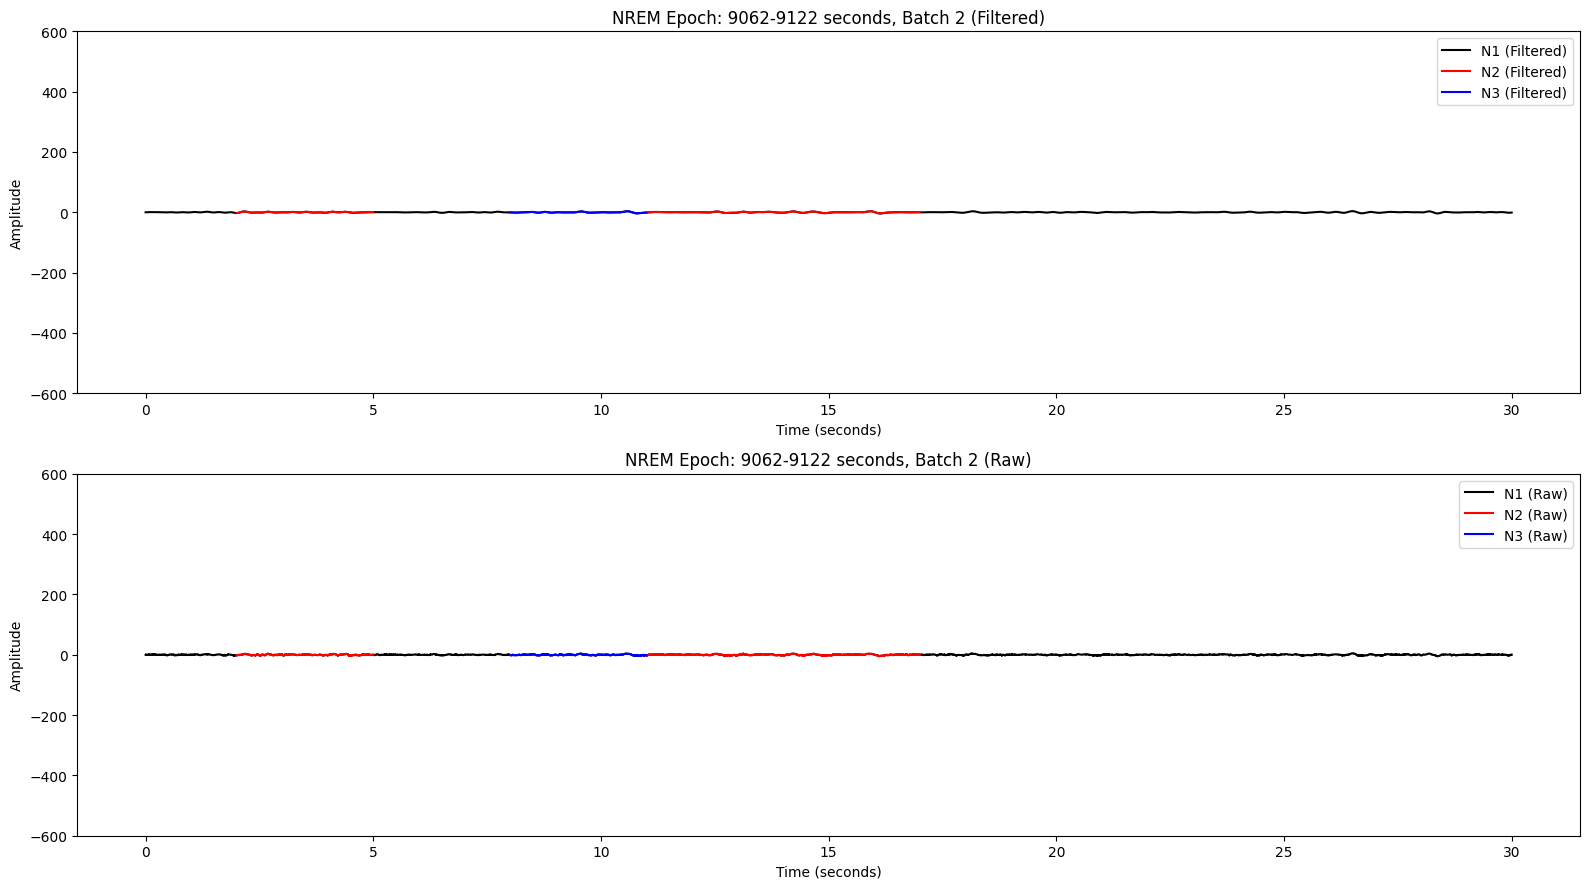

In [95]:
plot_nrem2(delta_signal, pfc_data, final_scores, start, end, 30, fs=1000)

## 10s window

In [96]:
so_cycles_rate, _ = rate_cycle(so_cycles_vector, duration=10, fs=1000)
delta_cycles_rate, _ = rate_cycle(delta_cycles_vector, duration=10, fs=1000)

Text(0.5, 0, 'Time (10 sec windows)')

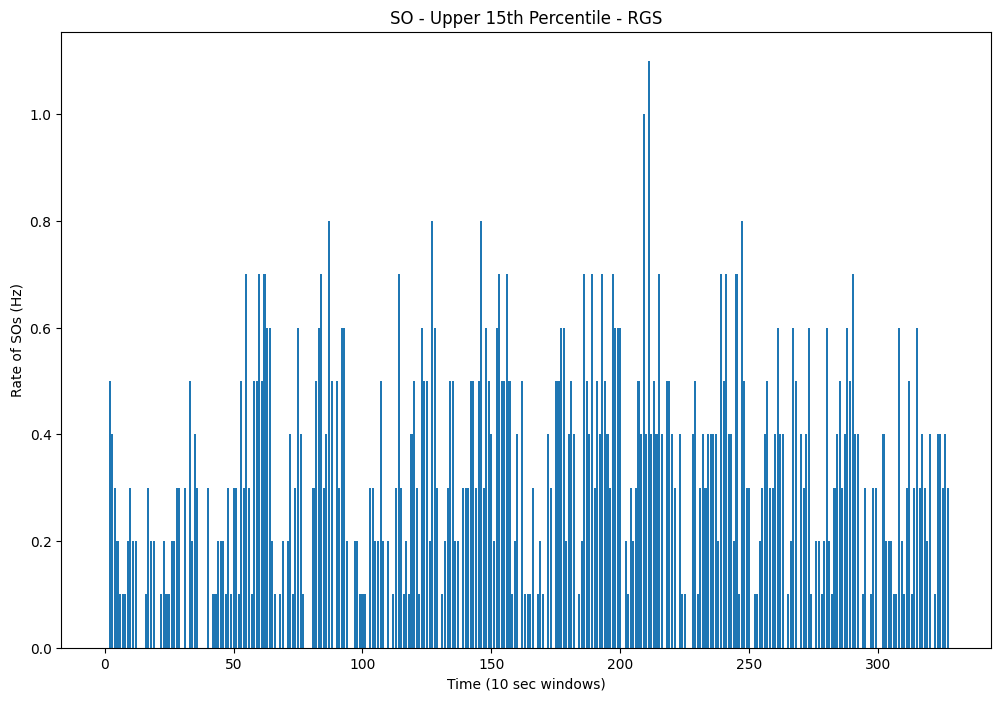

In [97]:
plt.figure(figsize=(12,8))

plt.title('SO - Upper 15th Percentile - RGS')
plt.bar(range(len(so_cycles_rate)), so_cycles_rate)
plt.ylabel("Rate of SOs (Hz)")
plt.xlabel("Time (10 sec windows)")

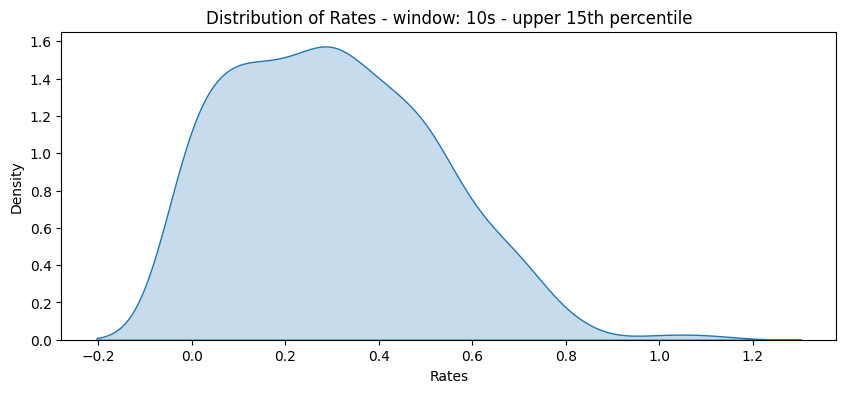

In [98]:
import seaborn as sns

plt.figure(figsize=(10, 4))
ax = sns.kdeplot(so_cycles_rate, fill=True)

ax.set_xlabel('Rates')
ax.set_ylabel('Density')

ax.set_title('Distribution of Rates - window: 10s - upper 15th percentile')


plt.show()

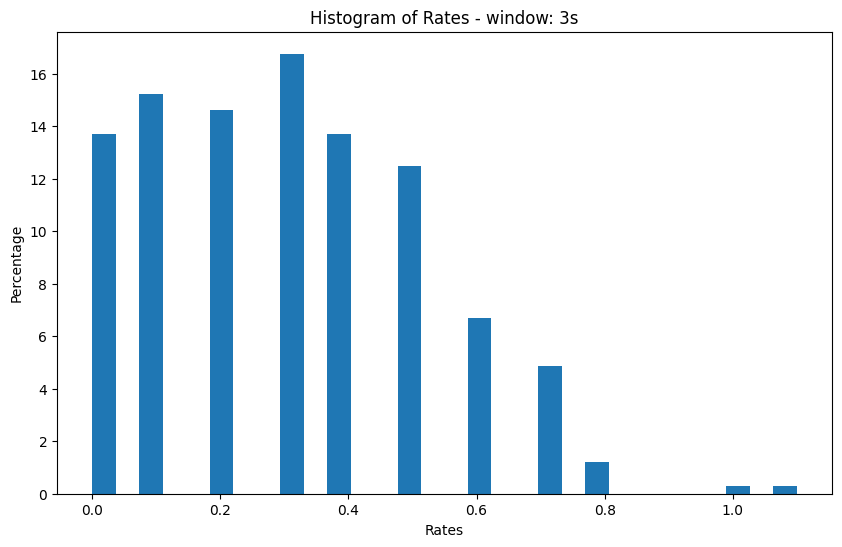

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)
plt.hist(so_cycles_rate, bins=30, weights=weights)
plt.xlabel('Rates')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - window: 3s')
plt.show()

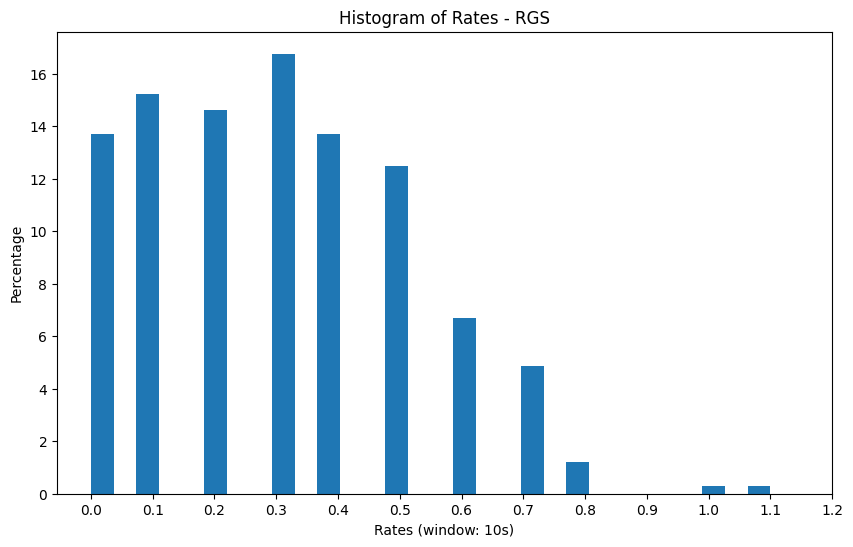

In [100]:
plt.figure(figsize=(10, 6))

weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)

plt.hist(so_cycles_rate, bins=30, weights=weights)

min_x = min(so_cycles_rate)
max_x = max(so_cycles_rate)
x_ticks = np.arange(min_x, max_x + 0.1, 0.1)
plt.xticks(x_ticks)

plt.xlabel('Rates (window: 10s)')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - RGS')
plt.show()

In [101]:
so_cycles_rate.shape

(328,)

In [102]:
def score_rates(so_cycles_rate):

  score_array = np.zeros_like(so_cycles_rate)
  for idx in range(len(so_cycles_rate)):
    if so_cycles_rate[idx] < 0.2:
      score_array[idx] = 1
    elif so_cycles_rate[idx] <=0.6 and so_cycles_rate[idx]  >= 0.2:
      score_array[idx] = 2
    else:
      score_array[idx] = 3
  return score_array

In [103]:
score_array = score_rates(so_cycles_rate)

In [104]:
np.unique(score_array)

array([1., 2., 3.])

Text(0.5, 0, 'Time')

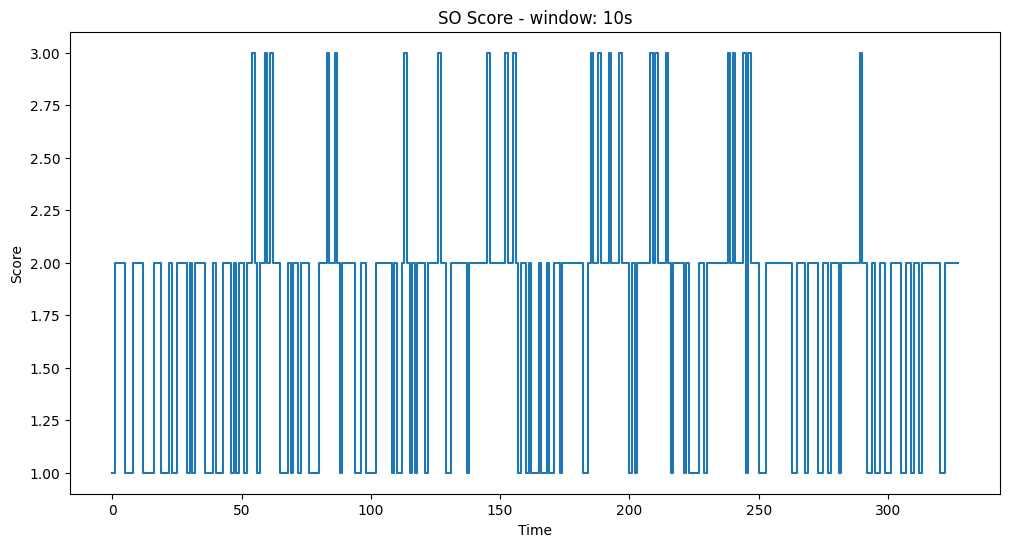

In [105]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score - window: 10s')
plt.ylabel('Score')
plt.xlabel('Time')

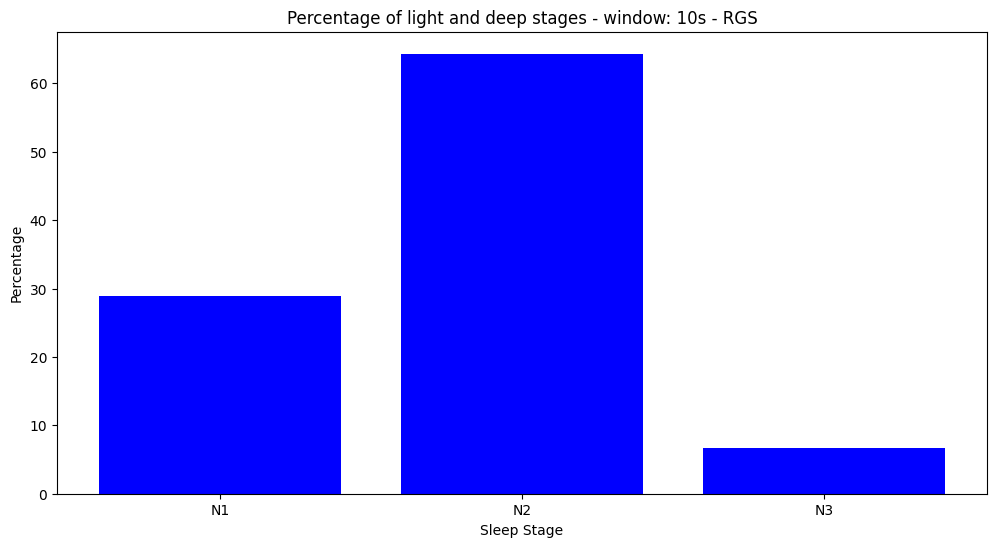

In [106]:
unique, counts = np.unique(score_array, return_counts=True)
percentages = counts / len(score_array) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["N1", "N2", "N3"], color=['b', 'b', 'b'])
plt.xlabel('Sleep Stage')
plt.ylabel('Percentage')
titlee = 'Percentage of light and deep stages - window: 10s - RGS'
plt.title(titlee)
plt.show()

## Criterias for merging

Text(0.5, 0, 'Time')

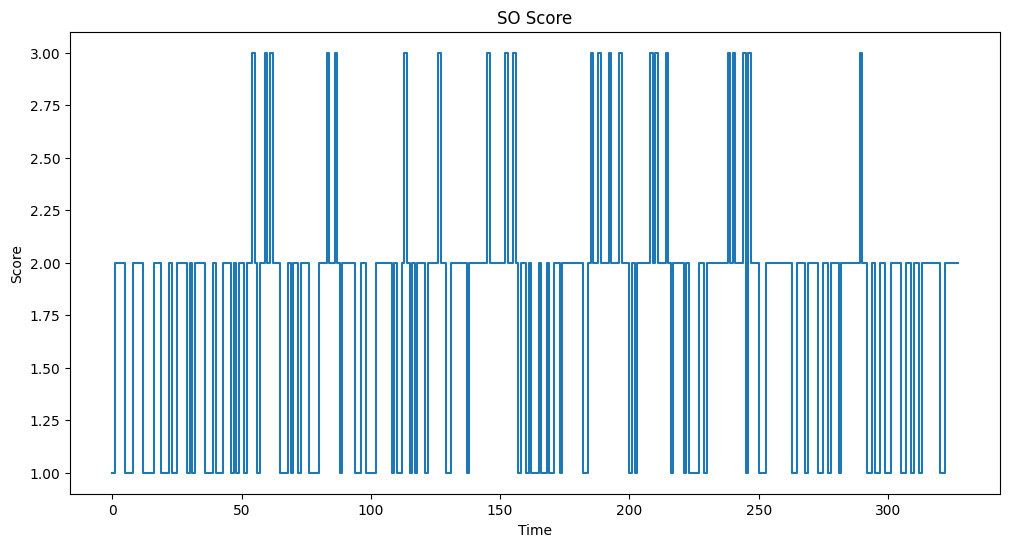

In [107]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score')
plt.ylabel('Score')
plt.xlabel('Time')

In [138]:
NREM_recunstruct = []

for score in score_array:
  for _ in range(10):
    NREM_recunstruct.append(score)
  NREM_recunstruct.append(score_array[-1])

In [139]:
len(NREM_recunstruct)

3608

In [140]:
for i, score in enumerate(NREM_recunstruct):
    NREM_recunstruct[i] = score + 5

In [141]:
len(NREM_recunstruct)

3608

In [142]:
def make_new_scoring(sleep_scoring, new_nrem, nrem_epochs):
    sleep_array = np.array(sleep_scoring)
    i = 0
    for start, end in nrem_epochs:
        segment_length = end - start
        sleep_array[start:end] = new_nrem[i:i + segment_length]
        i += segment_length
    return sleep_array

In [143]:
final_scores = make_new_scoring(states_RGS14, NREM_recunstruct, nrem_epochs)

In [144]:
for i in range(1, len(final_scores)):
  if final_scores[i] == 3:
    final_scores[i] = final_scores[i - 1]

In [145]:
for i, score in enumerate(final_scores):
  if score == 6:
    final_scores[i] = 2
  elif score == 7:
    final_scores[i] = 3
  elif score == 8:
    final_scores[i] = 4
  elif score == 4:
    final_scores[i] = 5
  elif score == 5:
    final_scores[i] = 6

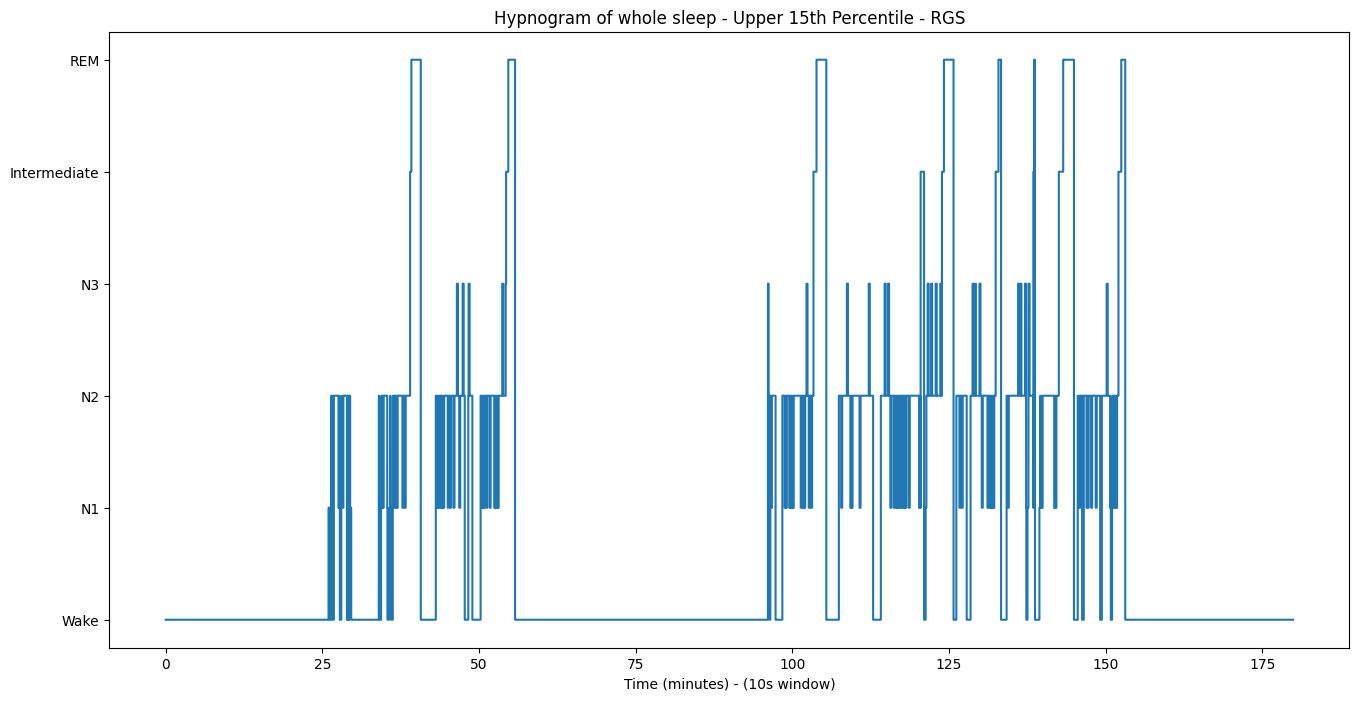

In [146]:
score_labels = {1: 'Wake', 2:'N1', 3:'N2', 4:'N3', 5: 'Intermediate', 6: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}
plt.figure(figsize=(16, 8))
time_minutes = np.arange(0, len(final_scores)) / 60
plt.step(time_minutes,final_scores)
plt.title('Hypnogram of whole sleep - Upper 15th Percentile - RGS')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xlabel("Time (minutes) - (10s window)")
plt.savefig('hypnogram_10s_15th.svg', format='svg')

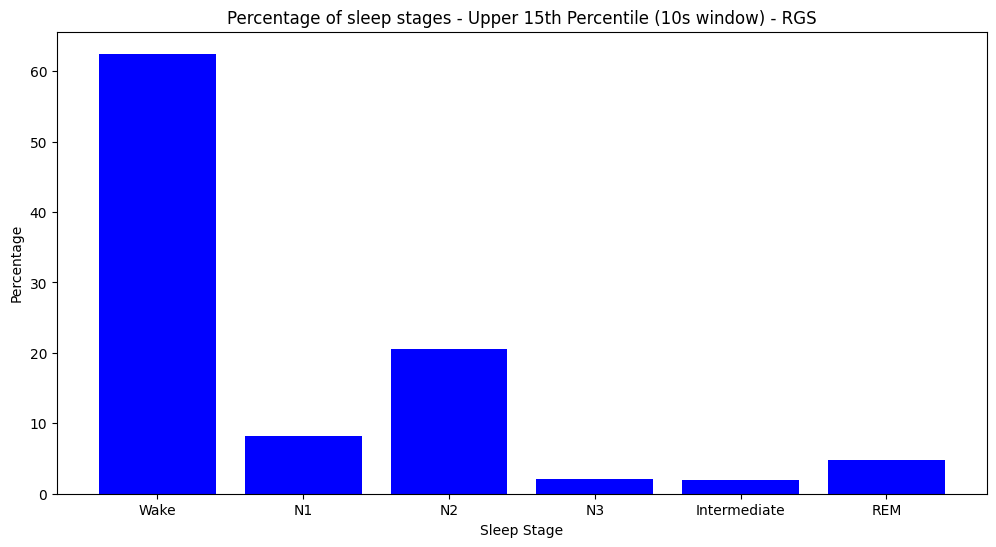

In [147]:
unique, counts = np.unique(final_scores, return_counts=True)
percentages = counts / len(final_scores) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["Wake", 'N1', 'N2', 'N3', 'Intermediate', 'REM'], color=['b', 'b', 'b', 'b', 'b', 'b'])
plt.xlabel('Sleep Stage')
plt.ylabel('Percentage')
titlee = 'Percentage of sleep stages - Upper 15th Percentile (10s window) - RGS'
plt.title(titlee)
plt.savefig('Percentage-10s-15th.svg', format='svg')
plt.show()

In [148]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nrem_epoch(filtered_signal, start_epoch, end_epoch, sleep_scoring, fs_signal=1000, fs_scoring=1):

    start_idx_signal = start_epoch * fs_signal
    end_idx_signal = end_epoch * fs_signal

    nrem_signal_segment = filtered_signal[start_idx_signal:end_idx_signal]
    nrem_scoring_segment = sleep_scoring[start_epoch:end_epoch]

    total_batches = int(np.ceil(len(nrem_signal_segment) / (20 * fs_signal)))

    for i in range(total_batches):
        batch_start_idx = i * 20 * fs_signal
        batch_end_idx = min((i + 1) * 20 * fs_signal, len(nrem_signal_segment))

        twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
        twenty_sec_stages = nrem_scoring_segment[i * 20: (i + 1) * 20]

        # Find indices for N1, N2, and N3 stages using np.where
        n1_indices = np.where(twenty_sec_stages == 2)[0]
        n2_indices = np.where(twenty_sec_stages == 3)[0]
        n3_indices = np.where(twenty_sec_stages == 4)[0]

        # Group consecutive indices into episodes
        def find_episodes(indices):
            episodes = []
            if len(indices) > 0:
                start = indices[0]
                for j in range(1, len(indices)):
                    if indices[j] != indices[j-1] + 1:
                        episodes.append((start, indices[j-1]))
                        start = indices[j]
                episodes.append((start, indices[-1]))
            return episodes

        n1_episodes = find_episodes(n1_indices)
        n2_episodes = find_episodes(n2_indices)
        n3_episodes = find_episodes(n3_indices)

        # Time axis for this batch
        t = np.arange(batch_start_idx / fs_signal, batch_end_idx / fs_signal, 1 / fs_signal)

        plt.figure(figsize=(16, 4.5))
        plt.plot(t, twenty_sec_sig, color='gray', label='Signal')

        for start_idx, end_idx in n1_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='green', label='N1' if start_idx == n1_episodes[0][0] else "")

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start_epoch}-{end_epoch} seconds, Batch {i+1}')

        # Set y-axis limits
        plt.ylim(-500, 500)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()


In [149]:
f_lowpass = 20
band = (0.1, 4)
n_cycles = 3
low_sig = filter_signal_fir(pfc_data, fs, 'lowpass', f_lowpass, n_cycles=n_cycles, remove_edges=False)
delta_signal = filter_signal_fir(low_sig, fs, 'bandpass', band, n_cycles=n_cycles, remove_edges=False)

In [150]:
def plot_nrem2(filtered_signal, raw_signal, scores, start, end, batch_length, fs=1000):

    # Segment the signals and scores
    filtered_signal_segment = filtered_signal[start * fs: end * fs]
    raw_signal_segment = raw_signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    # Calculate total number of batches
    total_batches = int(np.ceil(len(filtered_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):
        # Determine batch start and end indices
        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(filtered_signal_segment))

        # Extract the signal and stages for the current batch
        filtered_batch_sig = filtered_signal_segment[batch_start_idx:batch_end_idx]
        raw_batch_sig = raw_signal_segment[batch_start_idx:batch_end_idx]
        batch_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        # Extract N2 and N3 episodes
        n2_episodes = extract_n2_episodes(batch_stages)
        n3_episodes = extract_n3_episodes(batch_stages)

        # Generate time array dynamically based on the actual length of the segment
        t = np.arange(0, len(filtered_batch_sig) / fs, 1/fs)

        plt.figure(figsize=(16, 9))

        plt.subplot(2, 1, 1)
        plt.plot(t, filtered_batch_sig, color='black', label='N1 (Filtered)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Filtered)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Filtered)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Filtered)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.subplot(2, 1, 2)
        plt.plot(t, raw_batch_sig, color='black', label='N1 (Raw)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Raw)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Raw)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.savefig(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)-10s-15th.svg', format='svg')
        plt.show()

In [152]:
start, end = nrem_epochs[27]
print('start: ', start, ' end: ', end)
print((end - start + 1)/30)

start:  9062  end:  9122
2.033333333333333


Start: 9062, End: 9122
Total Batches: 2


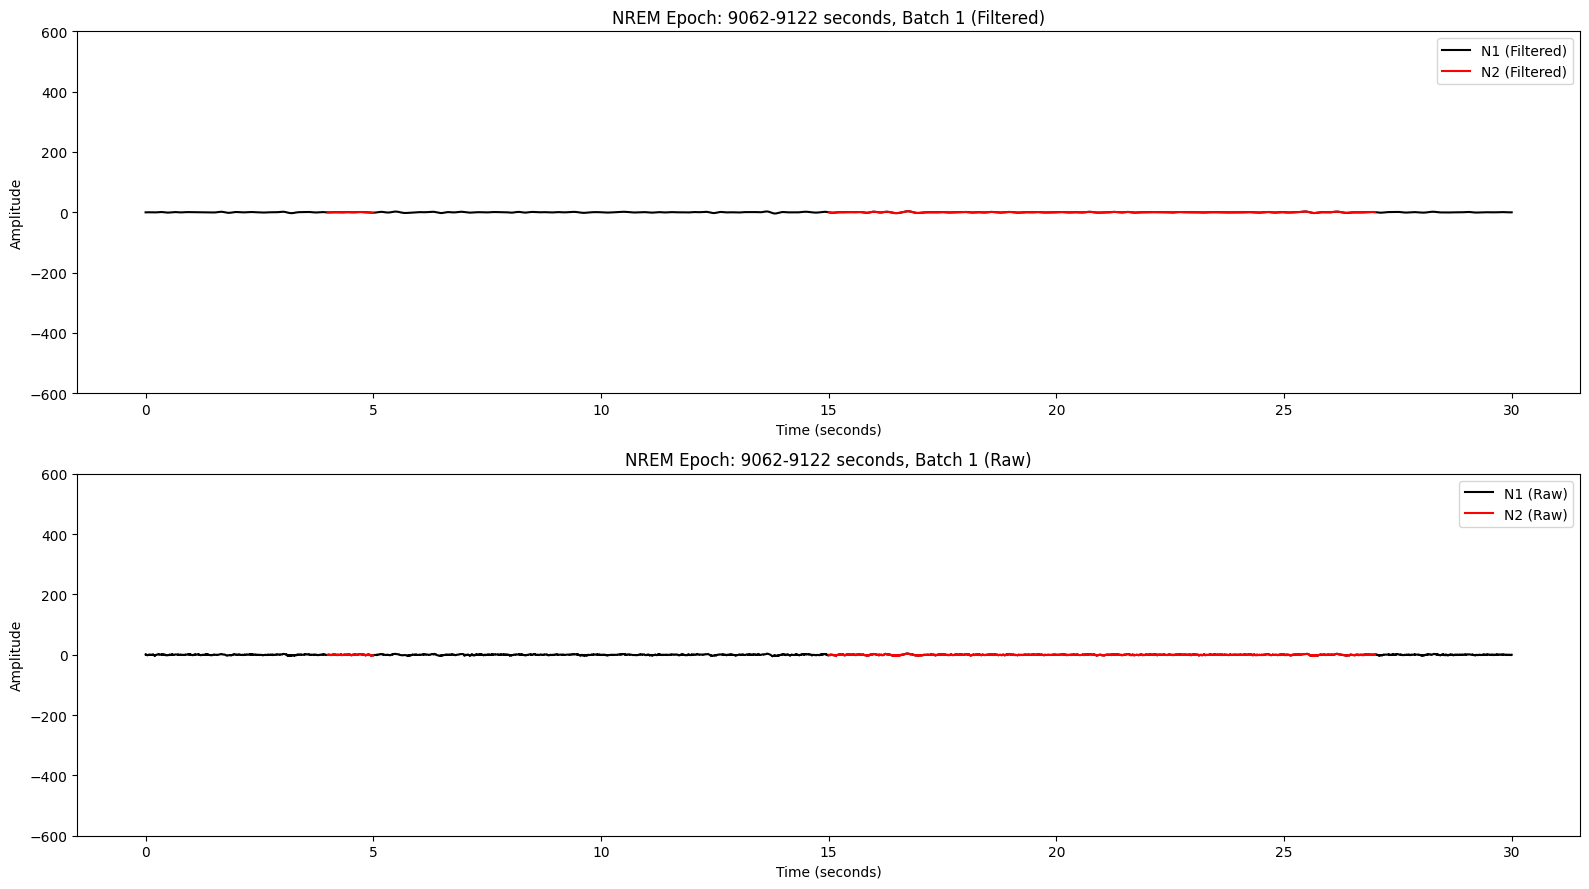

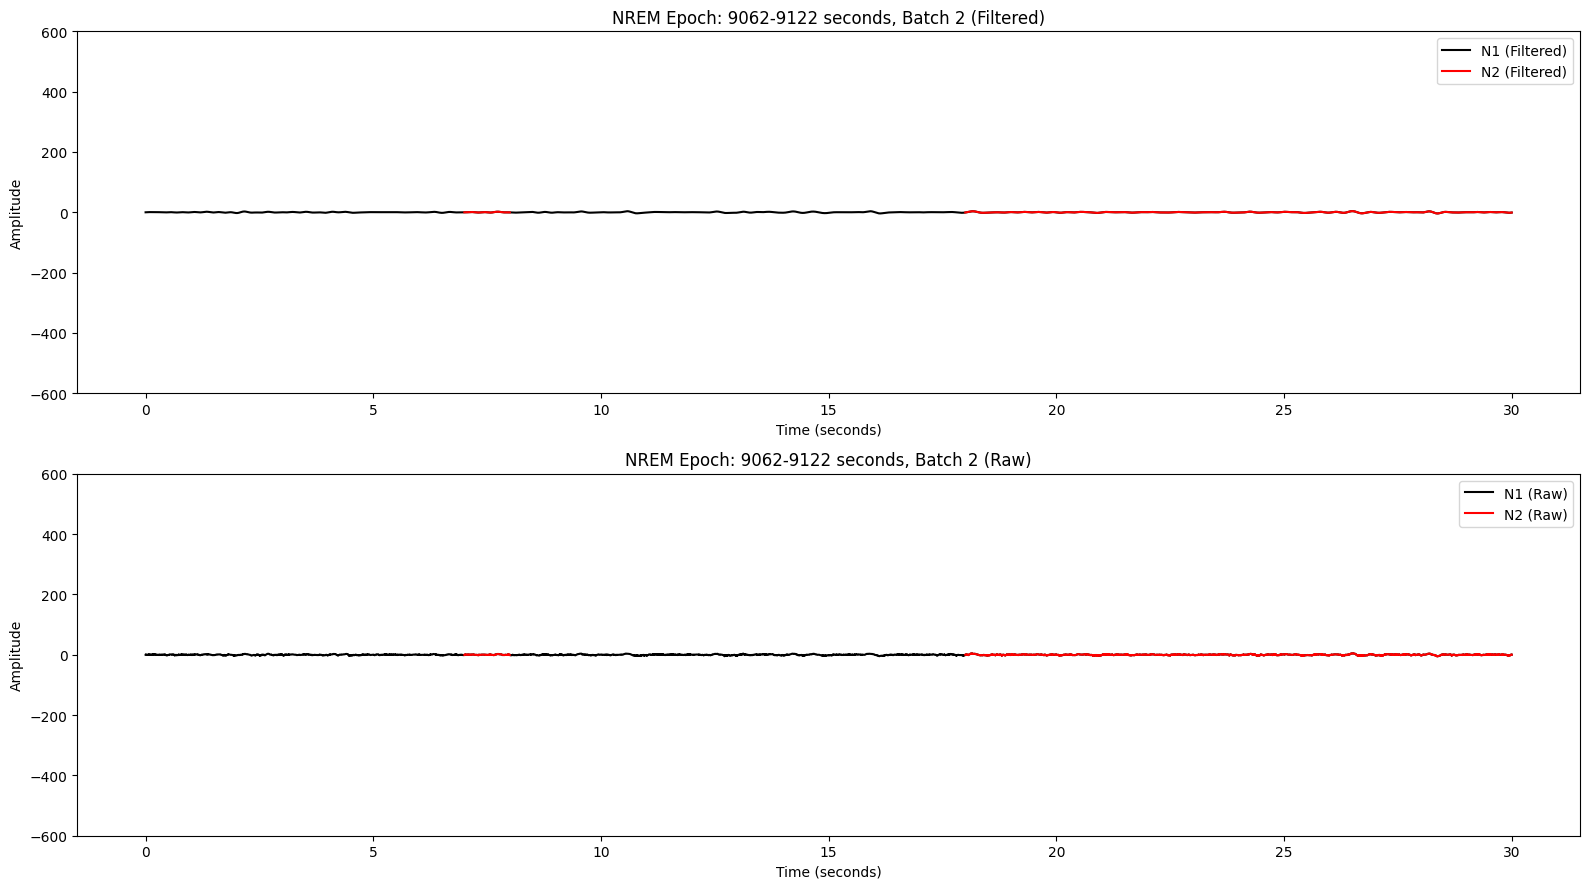

In [153]:
plot_nrem2(delta_signal, pfc_data, final_scores, start, end, 30, fs=1000)

Tetxt


# CBD

In [154]:
def find_all_NREM_epochs(arr):
    nrem_epochs = []
    start_index = None

    for i, num in enumerate(arr):
        if num == 3:
            if start_index is None:
                start_index = i
        elif num != 3 and start_index is not None:
            nrem_epochs.append([start_index, i - 1])
            start_index = None

    if start_index is not None:
        nrem_epochs.append([start_index, len(arr) - 1])

    return nrem_epochs

In [155]:
def peak_before_trough(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return arr[i]
  return -1

def peak_before_trough_pos(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return i
  return -1

def peak_to_trough_duration(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 20, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return trough_pos-i
  return -1

def num_inflection_points(arr):
  sign_changes = np.diff(np.sign(np.diff(arr, 2)))
  num_inflection_points = np.sum(sign_changes != 0)
  return num_inflection_points

def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

# Compute metrics for each cycle -
def get_cycles_with_metrics(cycles, data, IA, IF, conditions=None):
  C = copy.deepcopy(cycles)

  C.compute_cycle_metric('duration_samples', data, func=len)
  C.compute_cycle_metric('peak2trough', data, func=peak2trough)
  C.compute_cycle_metric('asc2desc', data, func=asc2desc)
  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('trough_values', data, func=np.min)
  C.compute_cycle_metric('peak_values', data, func=np.max)
  C.compute_cycle_metric('mean_if', IF, func=np.mean)
  C.compute_cycle_metric('max_if', IF, func=np.max)
  C.compute_cycle_metric('range_if', IF, func=compute_range)

  C.compute_cycle_metric('trough_position', data, func=np.argmin)
  C.compute_cycle_metric('peak_position', data, func=np.argmax)
  return C

In [156]:
nrem_epochs = find_all_NREM_epochs(states_CBD)

In [157]:
nrem_epochs

[[580, 1026],
 [1037, 1361],
 [1376, 1435],
 [1671, 1846],
 [2111, 2261],
 [2276, 2361],
 [2448, 2607],
 [2693, 2776],
 [2813, 2866],
 [3123, 3391],
 [3410, 3632],
 [3830, 3897],
 [3921, 4144],
 [6192, 6510],
 [6531, 6604],
 [6832, 7010],
 [7189, 7271],
 [7287, 7387],
 [7415, 7463],
 [7666, 7741],
 [7835, 7894]]

In [158]:
a = np.diff(nrem_epochs)

In [159]:
b = a[:, 0]

In [160]:
sum(b)

3247

In [161]:
# Joining all the NREM epochs and filtering the Delta band
fs = 2500 # Sampling rate/frequency
nrem_data = []
for start, end in nrem_epochs:
  pfc_data_part = lfp_CBD[start*fs:end*fs]
  nrem_data.extend(pfc_data_part)
nrem_data = np.array(nrem_data)

In [162]:
# #nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
# cut_off = 20
# low_sig = filter_signal_fir(nrem_data, fs, 'lowpass', cut_off, n_cycles=3, remove_edges=False)

Transition bandwidth is 0.2 Hz.
Pass/stop bandwidth is 3.9 Hz.


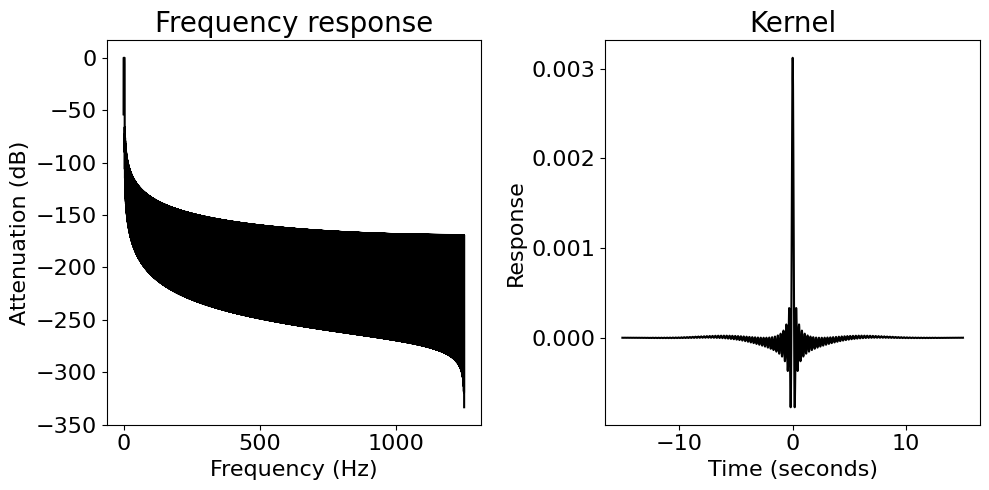

In [163]:
#nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
nrem_filtered_data = filter_signal_fir(nrem_data, fs,
                                       'bandpass', (0.1, 4),
                                       n_cycles=3, remove_edges=False,
                                       print_transitions=True, plot_properties=True)
# For testing, subset data
# nrem_filtered_data = nrem_filtered_data[:fs*60*10]

In [164]:
# Extract Instantaneous phase (IP), frequency and amplitude (from Hilbert Transform)
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, fs, 'hilbert')

# Get cycles using IP
C = emd.cycles.Cycles(IP)

 Checking Cycles inputs - trimming singleton from input 'IP'


In [165]:
cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)

In [166]:
def get_cycles_with_conditions(cycles, fs, conditions):
  C = copy.deepcopy(cycles)
  metrics = C.get_metric_dataframe()

  amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
  peak_thresh = np.percentile(metrics['peak_values'], 85)
  trough_thresh = np.percentile(metrics['trough_values'], 40)

  lo_freq_duration = fs/0.1
  hi_freq_duration = fs/4

  C.pick_cycle_subset(conditions)
  return C

In [167]:
metrics = cycles.get_metric_dataframe()
amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
peak_thresh = np.percentile(metrics['peak_values'], 85)
trough_thresh = np.percentile(metrics['trough_values'], 40)
lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [168]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
all_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [169]:
all_metrics = all_cycles.get_metric_dataframe(subset=True)
all_metrics

,index,is_good,duration_samples,peak2trough,asc2desc,max_amp,trough_values,peak_values,mean_if,max_if,range_if,trough_position,peak_position,chain_ind
0,2,1,916,0.562387,0.540195,628.153745,-481.936920,564.249829,2.728513,3.936866,1.549993,712,291,0
1,3,1,1187,0.335804,0.601332,577.077917,-528.724037,427.696489,2.106249,3.946991,3.051399,668,194,0
2,4,1,1348,0.647070,0.646522,311.792488,-282.786095,274.097346,1.854983,3.003183,2.300673,1098,621,0
3,6,1,797,0.544596,0.512321,281.007427,-184.836328,273.555279,3.136403,3.626147,0.952832,607,218,1
4,8,1,1237,0.467822,0.562762,585.481989,-547.661365,398.322000,2.021963,3.029111,1.228524,873,332,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,8830,1,1034,0.446907,0.561659,718.747678,-681.930644,553.131125,2.418986,2.911963,1.190366,705,252,1744
2718,8836,1,753,0.564937,0.514916,247.297694,-196.639827,244.560163,3.320305,4.120073,1.284485,591,226,1745
2719,8837,1,701,0.486843,0.496215,426.766233,-334.487493,243.647925,3.566205,4.032365,0.852122,531,178,1745
2720,8838,1,1364,0.342818,0.668193,583.445623,-367.910727,555.819708,1.833895,3.177575,2.830564,682,230,1745


## Get SO and delta cycles

In [170]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
so_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [171]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
delta_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [172]:
metrics_so = so_cycles.get_metric_dataframe(subset=True)
metrics_delta = delta_cycles.get_metric_dataframe(subset=True)

## Rate of SO and delta cycles

In [173]:
def get_masked_cycles(IP, cycles):
  mask = np.full(cycles.nsamples, False)
  subset_cycles = cycles.get_metric_dataframe(subset=True)['index']

  for i in subset_cycles:
    inds = cycles.get_inds_of_cycle(i)
    mask[inds] = True

  masked_so_cycles = emd.cycles.get_cycle_vector(IP, mask=mask)
  return masked_so_cycles

In [174]:
def rate_cycle(cycles_vector, duration=1, fs=1000):
  samples_per_segment = duration * fs
  segments = np.array_split(cycles_vector, np.arange(samples_per_segment, len(cycles_vector), samples_per_segment))
  segments = np.array(segments[:-1])

  rate = []
  for segment in segments:
    if -1 in segment:
      rate.append(len(np.unique(segment))-1)
    else:
      rate.append(len(np.unique(segment)))
  rate = np.array(rate)
  rate = rate/duration
  return rate, segments

In [175]:
so_cycles_vector = get_masked_cycles(IP, so_cycles)
delta_cycles_vector = get_masked_cycles(IP, delta_cycles)

## 3s window

In [176]:
so_cycles_rate, _ = rate_cycle(so_cycles_vector, duration=3, fs=2500)
delta_cycles_rate, _ = rate_cycle(delta_cycles_vector, duration=3, fs=2500)

Text(0.5, 0, 'Time (3 sec windows)')

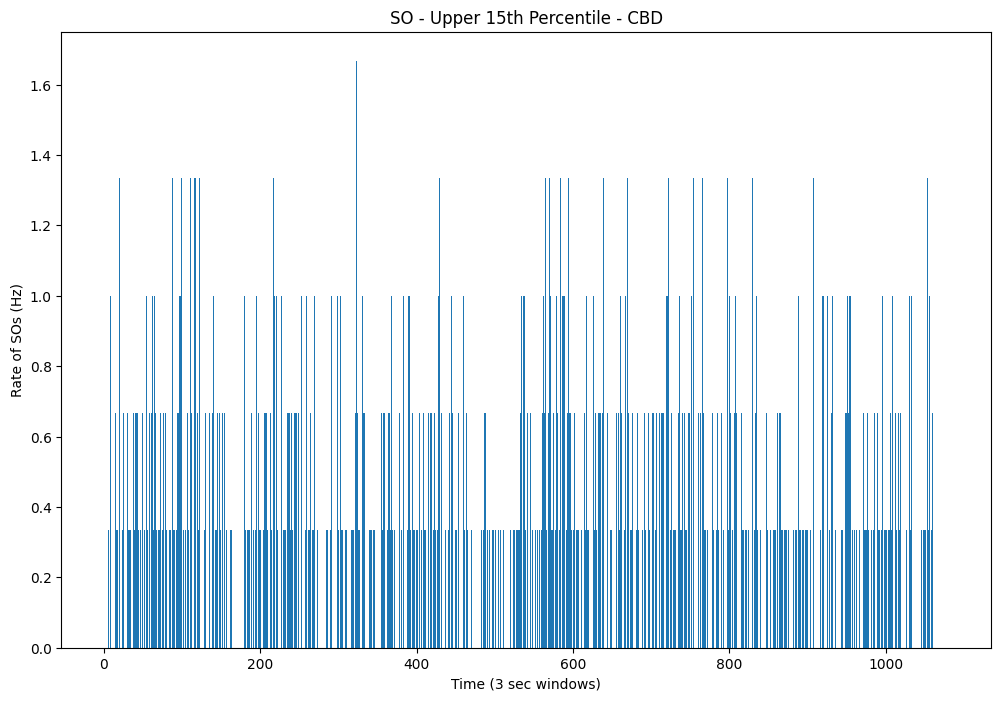

In [177]:
plt.figure(figsize=(12,8))

plt.title('SO - Upper 15th Percentile - CBD')
plt.bar(range(len(so_cycles_rate)), so_cycles_rate)
plt.ylabel("Rate of SOs (Hz)")
plt.xlabel("Time (3 sec windows)")

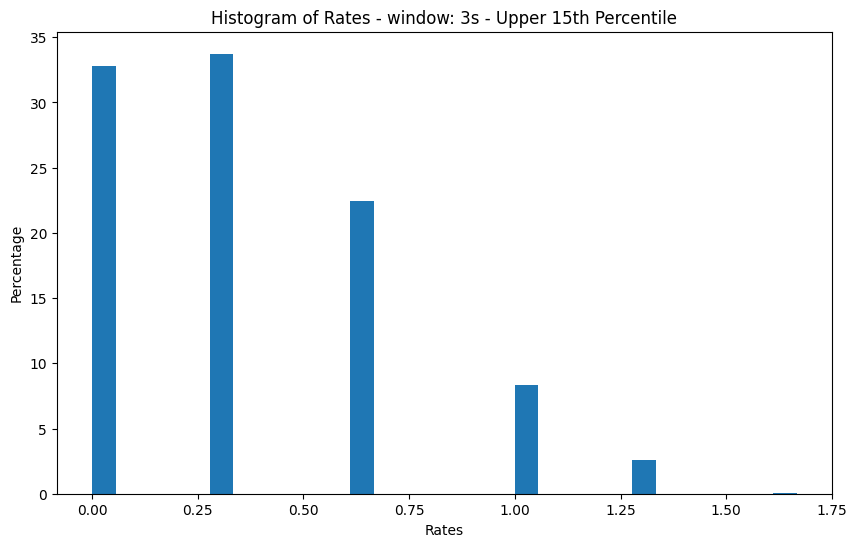

In [178]:
plt.figure(figsize=(10, 6))
weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)
plt.hist(so_cycles_rate, bins=30, weights=weights)
plt.xlabel('Rates')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - window: 3s - Upper 15th Percentile')
plt.show()

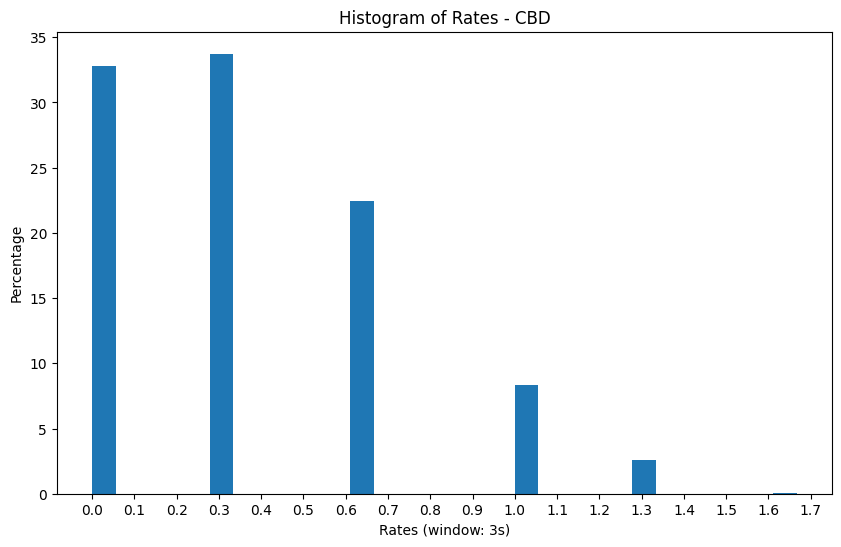

In [179]:
plt.figure(figsize=(10, 6))

weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)

plt.hist(so_cycles_rate, bins=30, weights=weights)

min_x = min(so_cycles_rate)
max_x = max(so_cycles_rate)
x_ticks = np.arange(min_x, max_x + 0.1, 0.1)
plt.xticks(x_ticks)

plt.xlabel('Rates (window: 3s)')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - CBD')
plt.show()

In [180]:
def score_rates(so_cycles_rate):

  score_array = np.zeros_like(so_cycles_rate)
  for idx in range(len(so_cycles_rate)):
    if so_cycles_rate[idx] < 0.2:
      score_array[idx] = 1
    elif so_cycles_rate[idx] <=0.8 and so_cycles_rate[idx]  >= 0.2:
      score_array[idx] = 2
    else:
      score_array[idx] = 3
  return score_array

In [181]:
score_array = score_rates(so_cycles_rate)

In [182]:
np.unique(score_array)

array([1., 2., 3.])

Text(0.5, 0, 'Time - window: 3s')

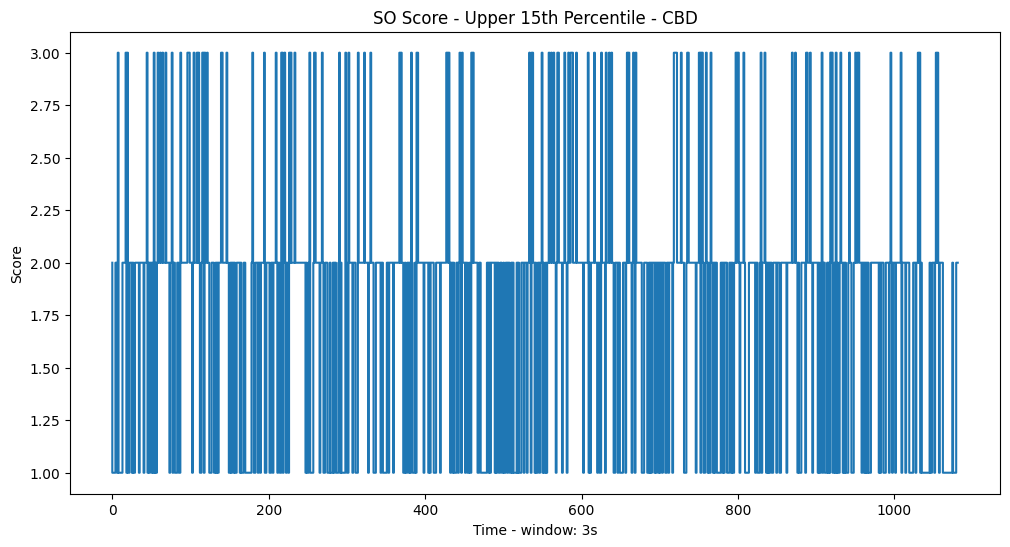

In [183]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score - Upper 15th Percentile - CBD')
plt.ylabel('Score')
plt.xlabel('Time - window: 3s')

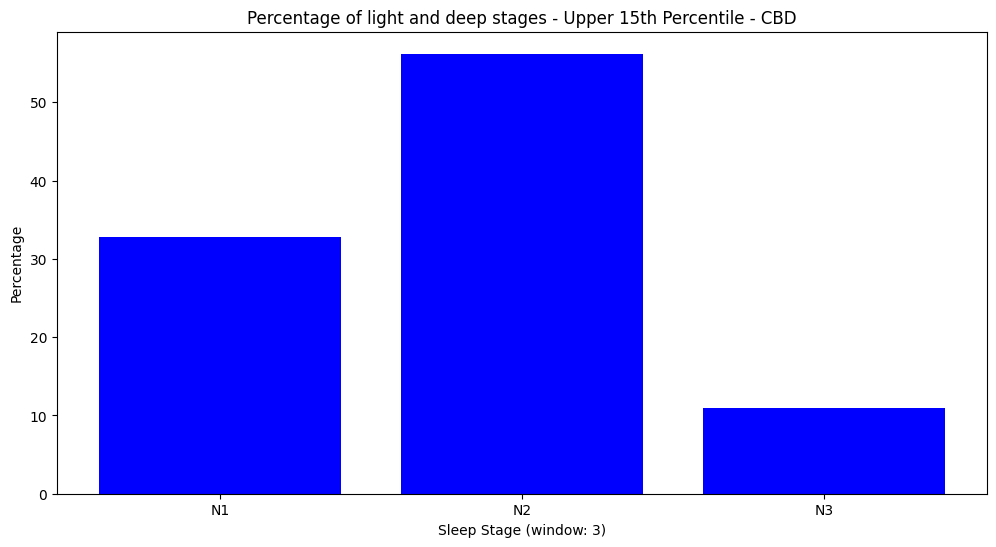

In [184]:
unique, counts = np.unique(score_array, return_counts=True)
percentages = counts / len(score_array) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["N1", "N2", "N3"], color=['b', 'b', 'b'])
plt.xlabel('Sleep Stage (window: 3)')
plt.ylabel('Percentage')
titlee = 'Percentage of light and deep stages - Upper 15th Percentile - CBD'
plt.title(titlee)
plt.show()

### Criterias for merging

Text(0.5, 0, 'Time')

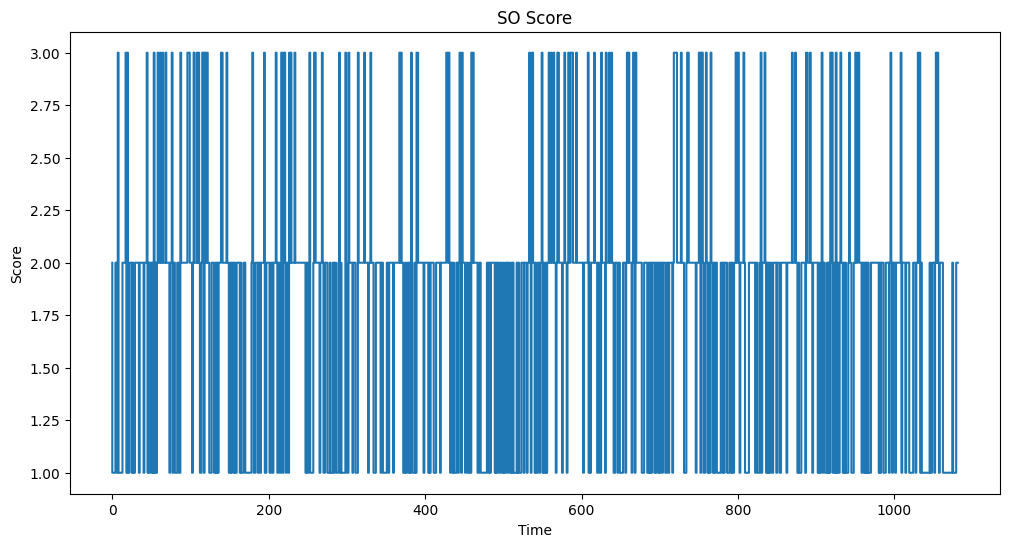

In [185]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score')
plt.ylabel('Score')
plt.xlabel('Time')

In [186]:
NREM_recunstruct = []

for score in score_array:
  for _ in range(3):
    NREM_recunstruct.append(score)
NREM_recunstruct.append(score_array[-1])

In [187]:
len(NREM_recunstruct)

3247

In [188]:
for i, score in enumerate(NREM_recunstruct):
    NREM_recunstruct[i] = score + 5

In [189]:
len(NREM_recunstruct)

3247

In [190]:
def make_new_scoring(sleep_scoring, new_nrem, nrem_epochs):
    sleep_array = np.array(sleep_scoring)
    i = 0
    for start, end in nrem_epochs:
        segment_length = end - start
        sleep_array[start:end] = new_nrem[i:i + segment_length]
        i += segment_length
    return sleep_array

In [192]:
final_scores = make_new_scoring(states_CBD, NREM_recunstruct, nrem_epochs)

In [193]:
len(final_scores)

10803

In [194]:
len(states_CBD)

10803

In [195]:
for i in range(1, len(final_scores)):
  if final_scores[i] == 3:
    final_scores[i] = final_scores[i - 1]

In [196]:
for i, score in enumerate(final_scores):
  if score == 6:
    final_scores[i] = 2
  elif score == 7:
    final_scores[i] = 3
  elif score == 8:
    final_scores[i] = 4
  elif score == 4:
    final_scores[i] = 5
  elif score == 5:
    final_scores[i] = 6

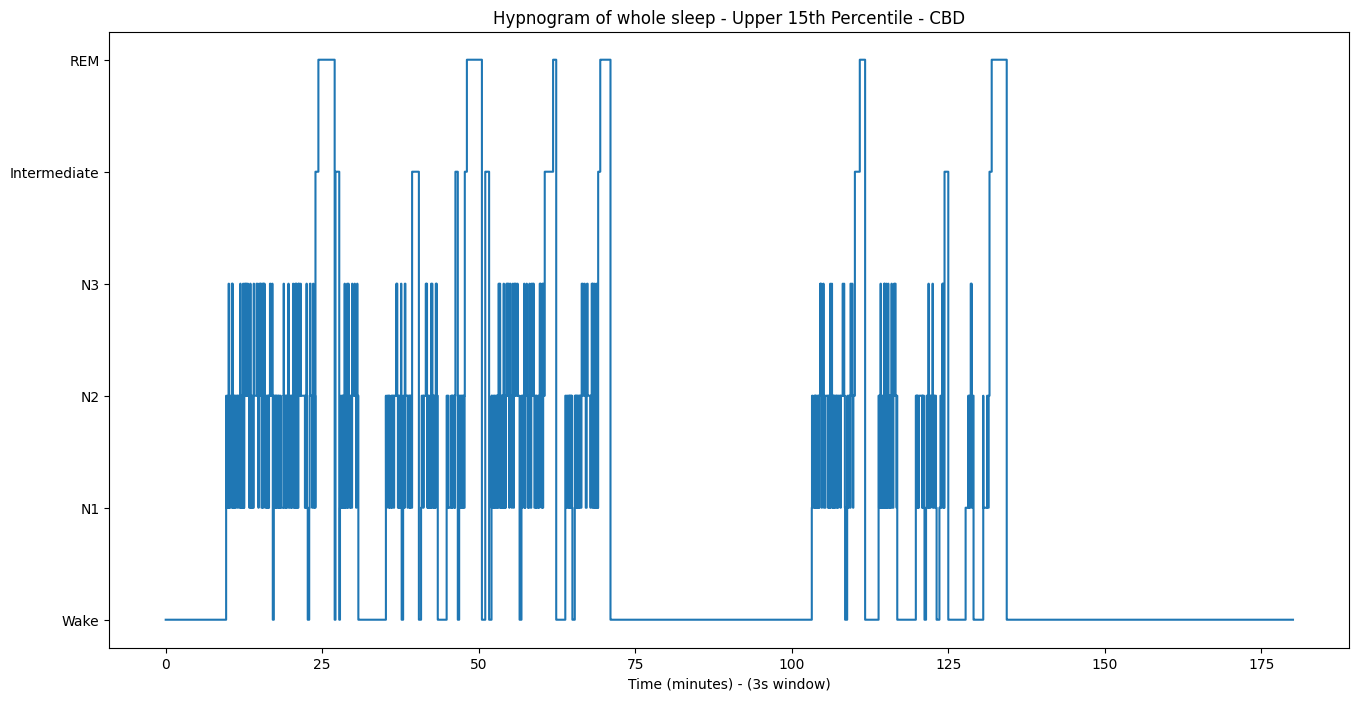

In [197]:
score_labels = {1: 'Wake', 2:'N1', 3:'N2', 4:'N3', 5: 'Intermediate', 6: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}
plt.figure(figsize=(16, 8))
time_minutes = np.arange(0, len(final_scores)) / 60
plt.step(time_minutes,final_scores)
plt.title('Hypnogram of whole sleep - Upper 15th Percentile - CBD')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xlabel("Time (minutes) - (3s window)")
plt.savefig('hypnogram_3s_15th.svg', format='svg')

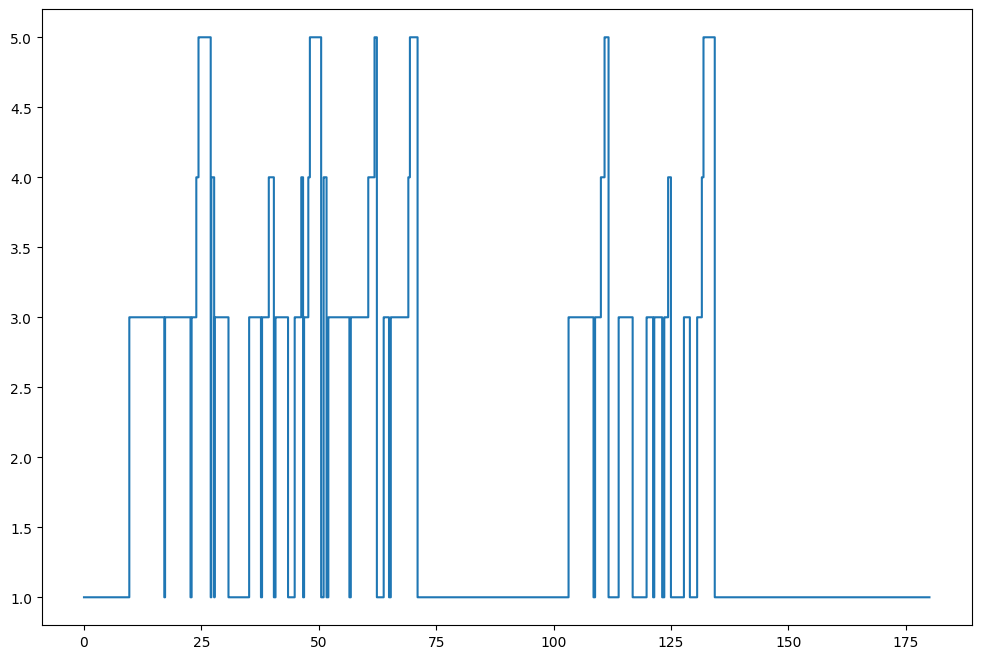

In [198]:
plt.figure(figsize=(12, 8))
time_minutes = np.arange(0, len(states_CBD)) / 60
plt.step(time_minutes,states_CBD)

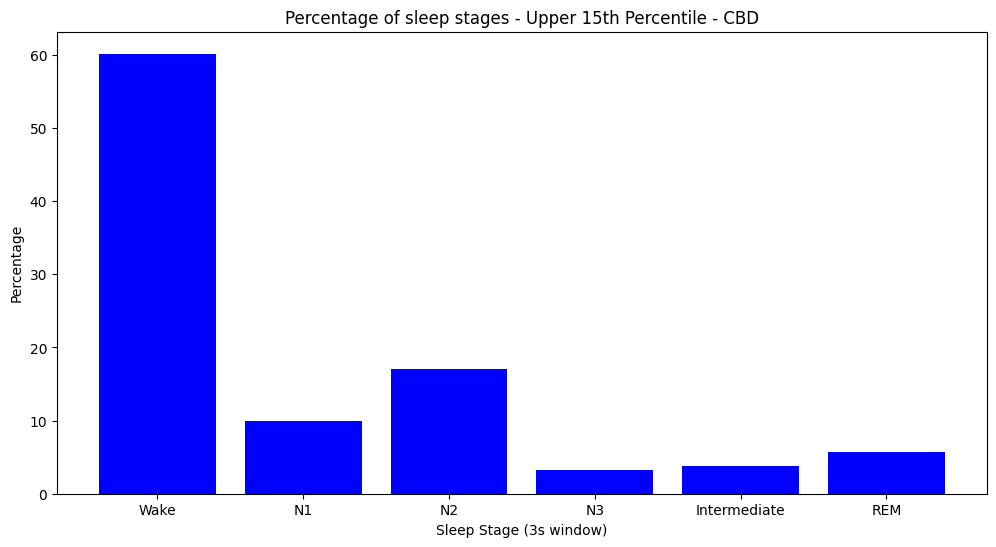

In [199]:
unique, counts = np.unique(final_scores, return_counts=True)
percentages = counts / len(final_scores) * 100

plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["Wake", 'N1', 'N2', 'N3', 'Intermediate', 'REM'], color=['b', 'b', 'b', 'b', 'b', 'b'])
plt.xlabel('Sleep Stage (3s window)')
plt.ylabel('Percentage')
titlee = 'Percentage of sleep stages - Upper 15th Percentile - CBD'
plt.title(titlee)
plt.savefig('Percentage-3s-15th.svg', format='svg')
plt.show()

In [200]:
f_lowpass = 20
band = (0.1, 4)
n_cycles = 3
low_sig = filter_signal_fir(pfc_data, fs, 'lowpass', f_lowpass, n_cycles=n_cycles, remove_edges=False)
delta_signal = filter_signal_fir(low_sig, fs, 'bandpass', band, n_cycles=n_cycles, remove_edges=False)

In [201]:
np.unique(final_scores)

array([1, 2, 3, 4, 5, 6], dtype=uint8)

In [202]:
def upscale_score(score_array, fs=1000):
  scores = []
  for i in range(len(score_array)):
    for _ in range(fs):
      scores.append(score_array[i])
  return scores

In [203]:
def extract_n2_episodes(sleep_stages):
    sleep_stages = np.asarray(sleep_stages).flatten()
    n2_indices = np.where(sleep_stages == 3)[0]

    episodes = []
    if len(n2_indices) == 0:
        return episodes

    start_idx = None
    for i in range(len(n2_indices)):
        if start_idx is None:
            start_idx = n2_indices[i]
        if i == len(n2_indices) - 1 or n2_indices[i + 1] != n2_indices[i] + 1:
            end_idx = n2_indices[i]
            episodes.append((start_idx, end_idx))
            start_idx = None

    return episodes

In [204]:
def extract_n3_episodes(sleep_stages):
    sleep_stages = np.asarray(sleep_stages).flatten()
    n3_indices = np.where(sleep_stages == 4)[0]

    episodes = []
    if len(n3_indices) == 0:
        return episodes

    start_idx = None
    for i in range(len(n3_indices)):
        if start_idx is None:
            start_idx = n3_indices[i]
        if i == len(n3_indices) - 1 or n3_indices[i + 1] != n3_indices[i] + 1:
            end_idx = n3_indices[i]
            episodes.append((start_idx, end_idx))
            start_idx = None

    return episodes

In [205]:
nrem_signal_segment = delta_signal[start*fs: end*fs]
score_segment = final_scores[start:end]
upscaled_scores = upscale_score(score_segment, fs=1000)

batch_length = 20

total_batches = int(np.ceil(len(nrem_signal_segment) / (batch_length * fs)))
print(start, ' ', end)
print(total_batches)
for i in range(total_batches):
    batch_start_idx = i * batch_length * fs
    batch_end_idx = min((i + 1) * batch_length * fs, len(nrem_signal_segment))

    twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
    twenty_sec_stages = upscaled_scores[batch_start_idx:batch_end_idx]

    n2_episodes = extract_n2_episodes(twenty_sec_stages)
    n3_episodes = extract_n3_episodes(twenty_sec_stages)

    t = np.arange(0, len(twenty_sec_sig) / fs, 1/fs)

    plt.figure(figsize=(16, 4.5))

    plt.plot(t, twenty_sec_sig, color='black', label='N1')

    for start_idx, end_idx in n2_episodes:
        plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

    for start_idx, end_idx in n3_episodes:
        plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Filtered Signal with Sleep Stages Highlighted - filtered between 0.5 to 4Hz')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

7835   7894
0


In [206]:
def plot_nrem(signal, scores, start, end, batch_length, fs=1000):

    nrem_signal_segment = signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    # Calculate total number of batches
    total_batches = int(np.ceil(len(nrem_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):
        # Determine batch start and end indices
        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(nrem_signal_segment))

        # Extract the signal and stages for the current batch
        twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
        twenty_sec_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        # Extract N2 and N3 episodes
        n2_episodes = extract_n2_episodes(twenty_sec_stages)
        n3_episodes = extract_n3_episodes(twenty_sec_stages)
        print(n2_episodes)
        print(n3_episodes)
        # Generate time array dynamically based on the actual length of the segment
        t = np.arange(0, len(twenty_sec_sig) / fs, 1/fs)

        plt.figure(figsize=(16, 4.5))
        plt.plot(t, twenty_sec_sig, color='black', label='N1')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1}')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()

Start: 7835, End: 7894
Total Batches: 3
[(0, 999)]
[]


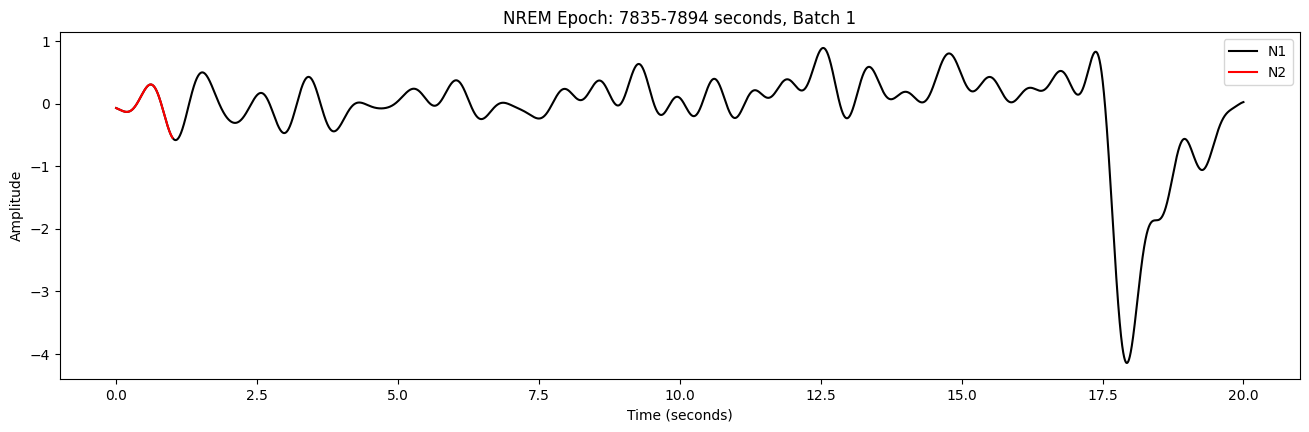

[(17000, 19999)]
[]


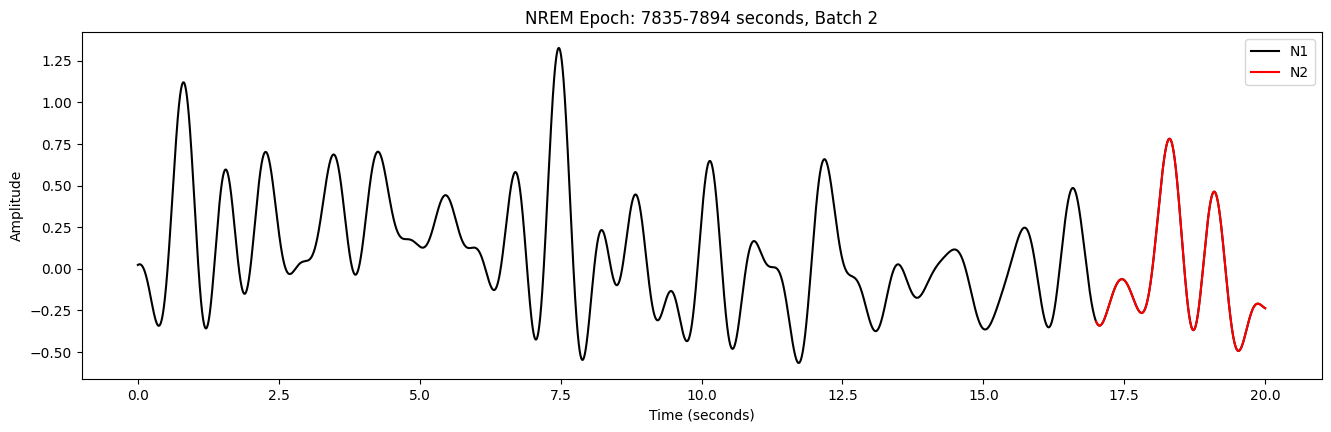

[(12000, 18999)]
[]


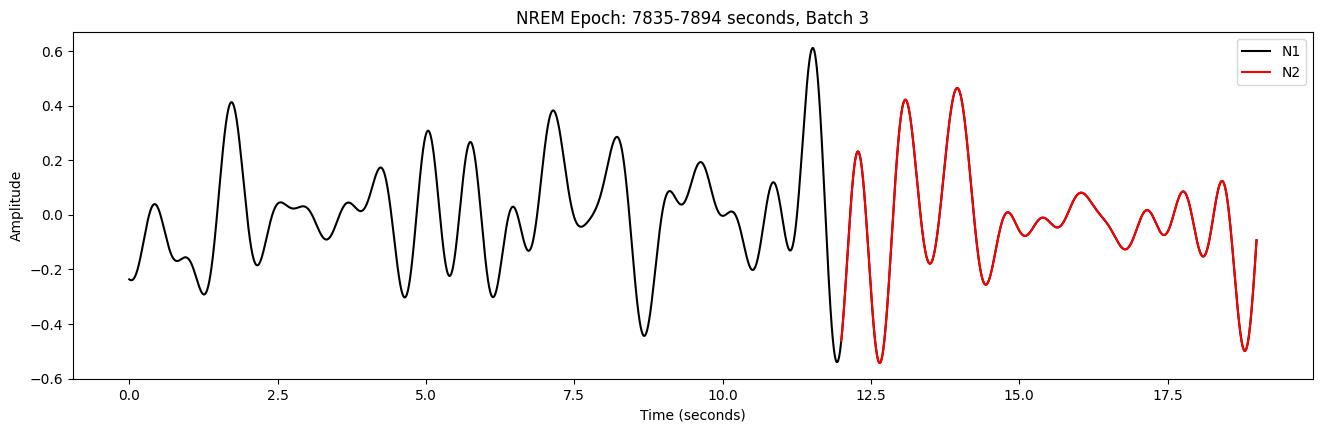

In [207]:
plot_nrem(delta_signal, final_scores, start, end, batch_length=20, fs=1000)

In [208]:
def plot_nrem2(filtered_signal, raw_signal, scores, start, end, batch_length, fs=1000):

    # Segment the signals and scores
    filtered_signal_segment = filtered_signal[start * fs: end * fs]
    raw_signal_segment = raw_signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    # Calculate total number of batches
    total_batches = int(np.ceil(len(filtered_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):
        # Determine batch start and end indices
        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(filtered_signal_segment))

        # Extract the signal and stages for the current batch
        filtered_batch_sig = filtered_signal_segment[batch_start_idx:batch_end_idx]
        raw_batch_sig = raw_signal_segment[batch_start_idx:batch_end_idx]
        batch_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        # Extract N2 and N3 episodes
        n2_episodes = extract_n2_episodes(batch_stages)
        n3_episodes = extract_n3_episodes(batch_stages)

        # Generate time array dynamically based on the actual length of the segment
        t = np.arange(0, len(filtered_batch_sig) / fs, 1/fs)

        # Create the figure and the first subplot for the filtered signal
        plt.figure(figsize=(16, 9))

        plt.subplot(2, 1, 1)
        plt.plot(t, filtered_batch_sig, color='black', label='N1 (Filtered)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Filtered)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Filtered)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Filtered)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.subplot(2, 1, 2)
        plt.plot(t, raw_batch_sig, color='black', label='N1 (Raw)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Raw)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Raw)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.savefig(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)-3s-15th.svg', format='svg')
        plt.show()

In [210]:
start, end = nrem_epochs[27]
print(start, end)
print((end - start + 1)/30)

IndexError: list index out of range

Start: 7835, End: 7894
Total Batches: 2


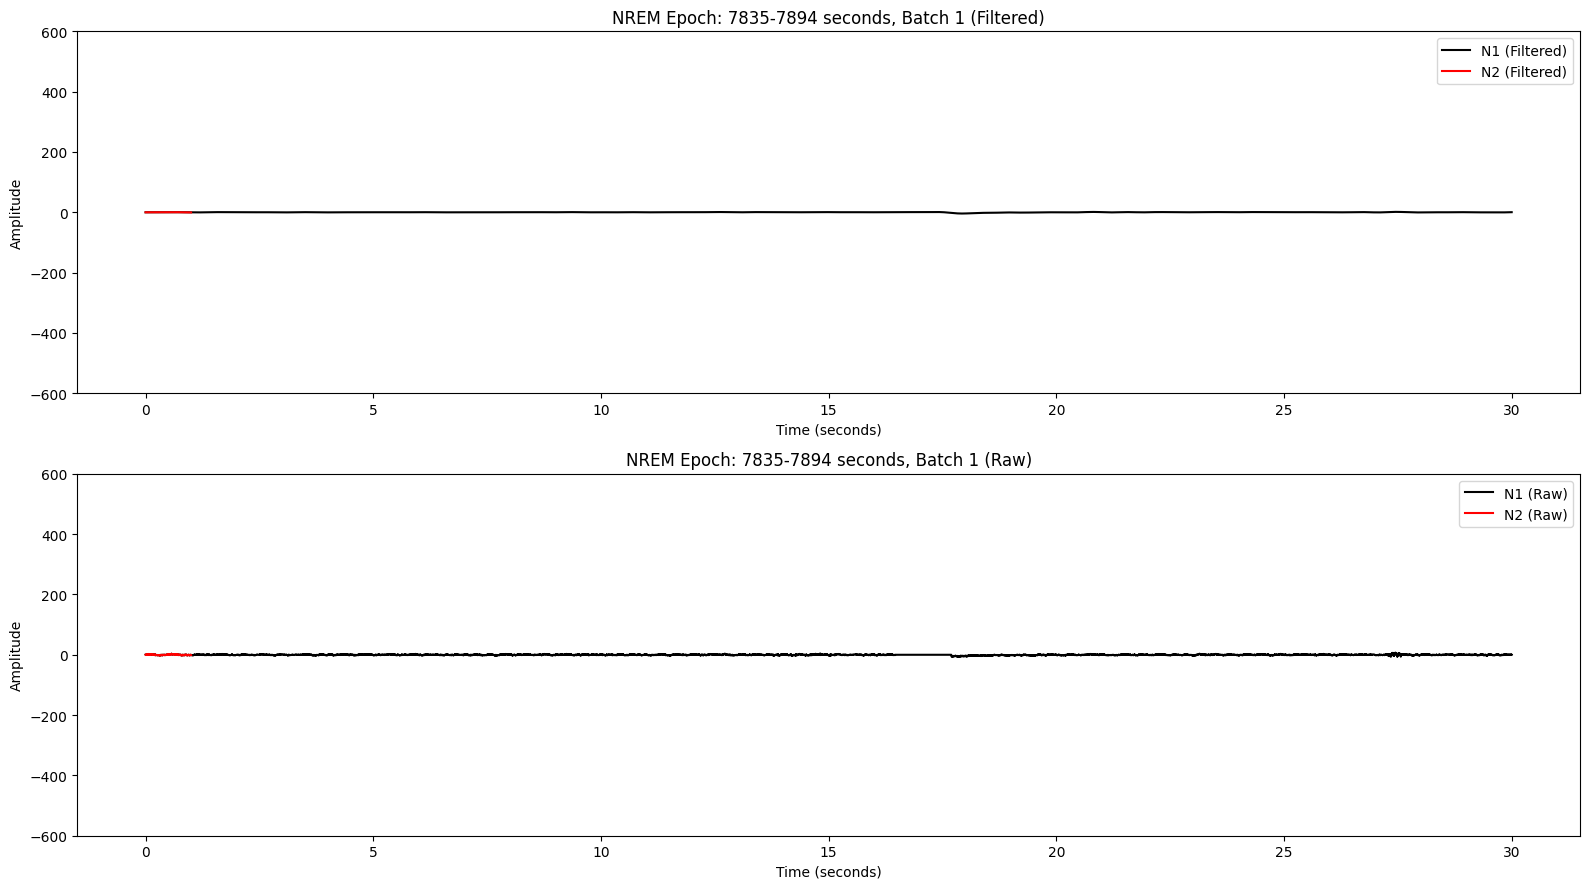

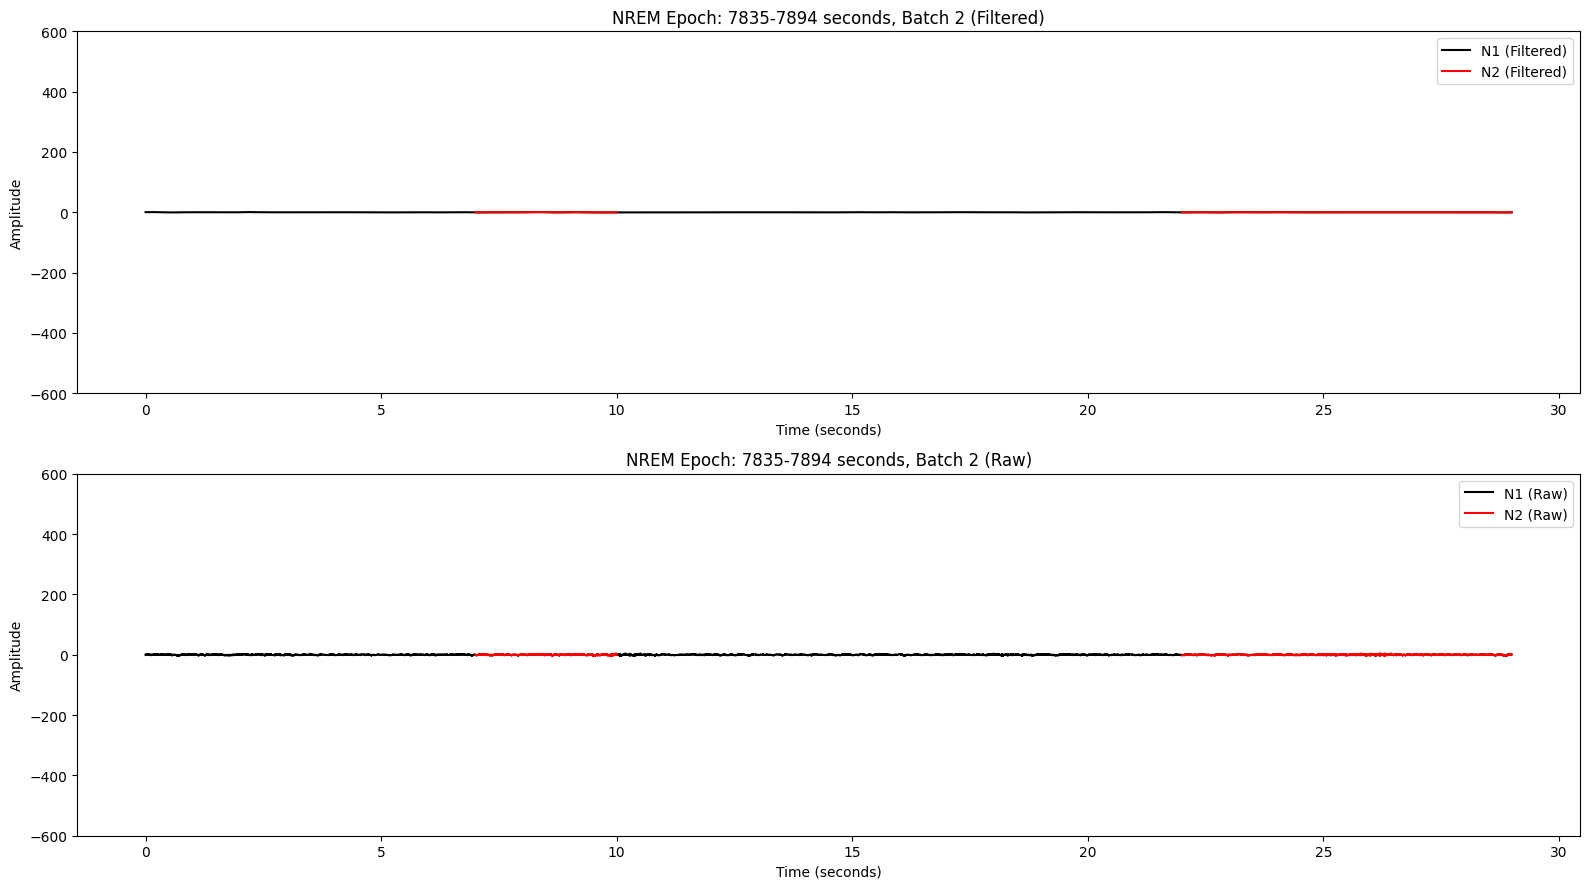

In [211]:
plot_nrem2(delta_signal, pfc_data, final_scores, start, end, 30, fs=1000)

## 10s window

In [ ]:
so_cycles_rate, _ = rate_cycle(so_cycles_vector, duration=10, fs=2500)
delta_cycles_rate, _ = rate_cycle(delta_cycles_vector, duration=10, fs=2500)

In [ ]:
plt.figure(figsize=(12,8))

plt.title('SO - Upper 15th Percentile - CBD')
plt.bar(range(len(so_cycles_rate)), so_cycles_rate)
plt.xlabel("Time (10 sec windows)")

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 4))
ax = sns.kdeplot(so_cycles_rate, fill=True)

ax.set_xlabel('Rates')
ax.set_ylabel('Density')

ax.set_title('Distribution of Rates - window: 10s - upper 15th percentile')


plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)
plt.hist(so_cycles_rate, bins=30, weights=weights)
plt.xlabel('Rates')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - window: 3s')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)

plt.hist(so_cycles_rate, bins=30, weights=weights)

min_x = min(so_cycles_rate)
max_x = max(so_cycles_rate)
x_ticks = np.arange(min_x, max_x + 0.1, 0.1)
plt.xticks(x_ticks)

plt.xlabel('Rates (window: 10s)')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - CBD')
plt.savefig('histo_rates_10s_50th.svg', format='svg')
plt.show()

In [ ]:
so_cycles_rate.shape

In [ ]:
def score_rates(so_cycles_rate):

  score_array = np.zeros_like(so_cycles_rate)
  for idx in range(len(so_cycles_rate)):
    if so_cycles_rate[idx] < 0.2:
      score_array[idx] = 1
    elif so_cycles_rate[idx] <=0.6 and so_cycles_rate[idx]  >= 0.2:
      score_array[idx] = 2
    else:
      score_array[idx] = 3
  return score_array

In [ ]:
score_array = score_rates(so_cycles_rate)

In [ ]:
np.unique(score_array)

In [ ]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score - window: 10s')
plt.ylabel('Score')
plt.xlabel('Time')

In [ ]:
unique, counts = np.unique(score_array, return_counts=True)
percentages = counts / len(score_array) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["N1", "N2", "N3"], color=['b', 'b', 'b'])
plt.xlabel('Sleep Stage')
plt.ylabel('Percentage')
titlee = 'Percentage of light and deep stages - window: 10s - CBD'
plt.title(titlee)
plt.show()

## Criterias for merging

In [ ]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score')
plt.ylabel('Score')
plt.xlabel('Time')

In [ ]:
NREM_recunstruct = []

for score in score_array:
  for _ in range(10):
    NREM_recunstruct.append(score)
for i in range(8):
  NREM_recunstruct.append(score_array[-1])

In [ ]:
len(NREM_recunstruct)

In [ ]:
for i, score in enumerate(NREM_recunstruct):
    NREM_recunstruct[i] = score + 5

In [ ]:
len(NREM_recunstruct)

In [ ]:
def make_new_scoring(sleep_scoring, new_nrem, nrem_epochs):
    sleep_array = np.array(sleep_scoring)
    i = 0
    for start, end in nrem_epochs:
        segment_length = end - start
        sleep_array[start:end] = new_nrem[i:i + segment_length]
        i += segment_length
    return sleep_array

In [ ]:
final_scores = make_new_scoring(states_CBD, NREM_recunstruct, nrem_epochs)

In [ ]:
for i in range(1, len(final_scores)):
  if final_scores[i] == 3:
    final_scores[i] = final_scores[i - 1]

In [ ]:
for i, score in enumerate(final_scores):
  if score == 6:
    final_scores[i] = 2
  elif score == 7:
    final_scores[i] = 3
  elif score == 8:
    final_scores[i] = 4
  elif score == 4:
    final_scores[i] = 5
  elif score == 5:
    final_scores[i] = 6

In [ ]:
score_labels = {1: 'Wake', 2:'N1', 3:'N2', 4:'N3', 5: 'Intermediate', 6: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}
plt.figure(figsize=(16, 8))
time_minutes = np.arange(0, len(final_scores)) / 60
plt.step(time_minutes,final_scores)
plt.title('Hypnogram of whole sleep - Upper 15th Percentile - CBD')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xlabel("Time (minutes) - (10s window)")

In [ ]:
unique, counts = np.unique(final_scores, return_counts=True)
percentages = counts / len(final_scores) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["Wake", 'N1', 'N2', 'N3', 'Intermediate', 'REM'], color=['b', 'b', 'b', 'b', 'b', 'b'])
plt.xlabel('Sleep Stage')
plt.ylabel('Percentage')
titlee = 'Percentage of sleep stages - Upper 15th Percentile (10s window) - CBD'
plt.title(titlee)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nrem_epoch(filtered_signal, start_epoch, end_epoch, sleep_scoring, fs_signal=1000, fs_scoring=1):
    # Calculate the corresponding indices in the signal
    start_idx_signal = start_epoch * fs_signal
    end_idx_signal = end_epoch * fs_signal

    # Get the corresponding NREM signal segment and sleep scoring segment
    nrem_signal_segment = filtered_signal[start_idx_signal:end_idx_signal]
    nrem_scoring_segment = sleep_scoring[start_epoch:end_epoch]

    # Calculate the total number of 20-second batches
    total_batches = int(np.ceil(len(nrem_signal_segment) / (20 * fs_signal)))

    for i in range(total_batches):
        batch_start_idx = i * 20 * fs_signal
        batch_end_idx = min((i + 1) * 20 * fs_signal, len(nrem_signal_segment))

        # Extract the 20-second batch for both signal and scoring
        twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
        twenty_sec_stages = nrem_scoring_segment[i * 20: (i + 1) * 20]

        # Find indices for N1, N2, and N3 stages using np.where
        n1_indices = np.where(twenty_sec_stages == 2)[0]
        n2_indices = np.where(twenty_sec_stages == 3)[0]
        n3_indices = np.where(twenty_sec_stages == 4)[0]

        def find_episodes(indices):
            episodes = []
            if len(indices) > 0:
                start = indices[0]
                for j in range(1, len(indices)):
                    if indices[j] != indices[j-1] + 1:
                        episodes.append((start, indices[j-1]))
                        start = indices[j]
                episodes.append((start, indices[-1]))
            return episodes

        n1_episodes = find_episodes(n1_indices)
        n2_episodes = find_episodes(n2_indices)
        n3_episodes = find_episodes(n3_indices)

        t = np.arange(batch_start_idx / fs_signal, batch_end_idx / fs_signal, 1 / fs_signal)

        # Plotting
        plt.figure(figsize=(16, 4.5))
        plt.plot(t, twenty_sec_sig, color='gray', label='Signal')

        for start_idx, end_idx in n1_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='green', label='N1' if start_idx == n1_episodes[0][0] else "")

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start_epoch}-{end_epoch} seconds, Batch {i+1}')

        # Set y-axis limits
        plt.ylim(-500, 500)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()


In [ ]:
f_lowpass = 20
band = (0.1, 4)
n_cycles = 3
low_sig = filter_signal_fir(pfc_data, fs, 'lowpass', f_lowpass, n_cycles=n_cycles, remove_edges=False)
delta_signal = filter_signal_fir(low_sig, fs, 'bandpass', band, n_cycles=n_cycles, remove_edges=False)

In [ ]:
def plot_nrem2(filtered_signal, raw_signal, scores, start, end, batch_length, fs=1000):

    # Segment the signals and scores
    filtered_signal_segment = filtered_signal[start * fs: end * fs]
    raw_signal_segment = raw_signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    # Calculate total number of batches
    total_batches = int(np.ceil(len(filtered_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):
        # Determine batch start and end indices
        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(filtered_signal_segment))

        # Extract the signal and stages for the current batch
        filtered_batch_sig = filtered_signal_segment[batch_start_idx:batch_end_idx]
        raw_batch_sig = raw_signal_segment[batch_start_idx:batch_end_idx]
        batch_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        # Extract N2 and N3 episodes
        n2_episodes = extract_n2_episodes(batch_stages)
        n3_episodes = extract_n3_episodes(batch_stages)

        # Generate time array dynamically based on the actual length of the segment
        t = np.arange(0, len(filtered_batch_sig) / fs, 1/fs)

        # Create the figure and the first subplot for the filtered signal
        plt.figure(figsize=(16, 9))

        # Plot the filtered signal with sleep stages highlighted
        plt.subplot(2, 1, 1)
        plt.plot(t, filtered_batch_sig, color='black', label='N1 (Filtered)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Filtered)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Filtered)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Filtered)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        # Plot the raw signal in the second subplot
        plt.subplot(2, 1, 2)
        plt.plot(t, raw_batch_sig, color='black', label='N1 (Raw)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Raw)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Raw)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.savefig(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)-10s-15th.svg', format='svg')
        plt.show()

In [ ]:
start, end = nrem_epochs[31]
print('start: ', start, ' end: ', end)
print((end - start + 1)/30)

In [ ]:
plot_nrem2(delta_signal, pfc_data, final_scores, start, end, 30, fs=1000)

Tetxt


# OS

In [ ]:
def find_all_NREM_epochs(arr):
    nrem_epochs = []
    start_index = None

    for i, num in enumerate(arr):
        if num == 3:
            if start_index is None:
                start_index = i
        elif num != 3 and start_index is not None:
            nrem_epochs.append([start_index, i - 1])
            start_index = None

    if start_index is not None:
        nrem_epochs.append([start_index, len(arr) - 1])

    return nrem_epochs

In [ ]:
def peak_before_trough(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return arr[i]
  return -1

def peak_before_trough_pos(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return i
  return -1

def peak_to_trough_duration(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 20, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return trough_pos-i
  return -1

def num_inflection_points(arr):
  sign_changes = np.diff(np.sign(np.diff(arr, 2)))
  num_inflection_points = np.sum(sign_changes != 0)
  return num_inflection_points

def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

# Compute metrics for each cycle -
def get_cycles_with_metrics(cycles, data, IA, IF, conditions=None):
  C = copy.deepcopy(cycles)

  C.compute_cycle_metric('duration_samples', data, func=len)
  C.compute_cycle_metric('peak2trough', data, func=peak2trough)
  C.compute_cycle_metric('asc2desc', data, func=asc2desc)
  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('trough_values', data, func=np.min)
  C.compute_cycle_metric('peak_values', data, func=np.max)
  C.compute_cycle_metric('mean_if', IF, func=np.mean)
  C.compute_cycle_metric('max_if', IF, func=np.max)
  C.compute_cycle_metric('range_if', IF, func=compute_range)

  C.compute_cycle_metric('trough_position', data, func=np.argmin)
  C.compute_cycle_metric('peak_position', data, func=np.argmax)
  return C

In [ ]:
nrem_epochs = find_all_NREM_epochs(states_OSB)

In [ ]:
nrem_epochs

In [ ]:
a = np.diff(nrem_epochs)

In [ ]:
b = a[:, 0]

In [ ]:
sum(b)

In [ ]:
# Joining all the NREM epochs and filtering the Delta band

fs = 2500 # Sampling rate/frequency
nrem_data_OSB = []
for start, end in nrem_epochs:
  pfc_data_part_OSB = lfp_OSB[start*fs:end*fs]
  nrem_data_OSB.extend(pfc_data_part_OSB)
nrem_data_OSB = np.array(nrem_data_OSB)

In [ ]:
# #nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
# cut_off = 20
# low_sig = filter_signal_fir(nrem_data, fs, 'lowpass', cut_off, n_cycles=3, remove_edges=False)

In [ ]:
fs

In [ ]:
#nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
nrem_filtered_data = filter_signal_fir(nrem_data_OSB, fs,
                                       'bandpass', (0.1, 4),
                                       n_cycles=3, remove_edges=False)
# For testing, subset data
# nrem_filtered_data = nrem_filtered_data[:fs*60*10]

In [ ]:
# Extract Instantaneous phase (IP), frequency and amplitude (from Hilbert Transform)
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, fs, 'hilbert')

# Get cycles using IP
C = emd.cycles.Cycles(IP)

In [ ]:
cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)

In [ ]:
def get_cycles_with_conditions(cycles, fs, conditions):
  C = copy.deepcopy(cycles)
  metrics = C.get_metric_dataframe()

  amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
  peak_thresh = np.percentile(metrics['peak_values'], 85)
  trough_thresh = np.percentile(metrics['trough_values'], 40)

  lo_freq_duration = fs/0.1
  hi_freq_duration = fs/4

  C.pick_cycle_subset(conditions)
  return C

In [ ]:
metrics = cycles.get_metric_dataframe()
amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
peak_thresh = np.percentile(metrics['peak_values'], 85)
trough_thresh = np.percentile(metrics['trough_values'], 40)
lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [ ]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
all_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [ ]:
all_metrics = all_cycles.get_metric_dataframe(subset=True)
all_metrics

## Get SO and delta cycles

In [ ]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
so_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [ ]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
delta_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [ ]:
metrics_so = so_cycles.get_metric_dataframe(subset=True)
metrics_delta = delta_cycles.get_metric_dataframe(subset=True)

## Rate of SO and delta cycles

In [ ]:
def get_masked_cycles(IP, cycles):
  mask = np.full(cycles.nsamples, False)
  subset_cycles = cycles.get_metric_dataframe(subset=True)['index']

  for i in subset_cycles:
    inds = cycles.get_inds_of_cycle(i)
    mask[inds] = True

  masked_so_cycles = emd.cycles.get_cycle_vector(IP, mask=mask)
  return masked_so_cycles

In [ ]:
def rate_cycle(cycles_vector, duration=1, fs=1000):
  samples_per_segment = duration * fs
  segments = np.array_split(cycles_vector, np.arange(samples_per_segment, len(cycles_vector), samples_per_segment))
  segments = np.array(segments[:-1])

  rate = []
  for segment in segments:
    if -1 in segment:
      rate.append(len(np.unique(segment))-1)
    else:
      rate.append(len(np.unique(segment)))
  rate = np.array(rate)
  rate = rate/duration
  return rate, segments

In [ ]:
so_cycles_vector = get_masked_cycles(IP, so_cycles)
delta_cycles_vector = get_masked_cycles(IP, delta_cycles)

## 3s window

In [ ]:
so_cycles_rate, _ = rate_cycle(so_cycles_vector, duration=3, fs=2500)
delta_cycles_rate, _ = rate_cycle(delta_cycles_vector, duration=3, fs=2500)

In [ ]:
plt.figure(figsize=(12,8))

plt.title('SO - Upper 15th Percentile - OS Basic')
plt.bar(range(len(so_cycles_rate)), so_cycles_rate)
plt.ylabel("Rate of SOs (Hz)")
plt.xlabel("Time (3 sec windows)")
plt.savefig('SO_rates_3s_15th.svg', format='svg')

In [ ]:
plt.figure(figsize=(10, 6))
weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)
plt.hist(so_cycles_rate, bins=30, weights=weights)
plt.xlabel('Rates')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - window: 3s - Upper 15th Percentile')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)

plt.hist(so_cycles_rate, bins=30, weights=weights)

min_x = min(so_cycles_rate)
max_x = max(so_cycles_rate)
x_ticks = np.arange(min_x, max_x + 0.1, 0.1)
plt.xticks(x_ticks)

plt.xlabel('Rates (window: 3s)')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - OS Basic')
plt.show()

In [ ]:
def score_rates(so_cycles_rate):

  score_array = np.zeros_like(so_cycles_rate)
  for idx in range(len(so_cycles_rate)):
    if so_cycles_rate[idx] < 0.3:
      score_array[idx] = 1
    elif so_cycles_rate[idx] <=0.8 and so_cycles_rate[idx]  >= 0.3:
      score_array[idx] = 2
    else:
      score_array[idx] = 3
  return score_array

In [ ]:
score_array = score_rates(so_cycles_rate)

In [ ]:
np.unique(score_array)

In [ ]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score - Upper 15th Percentile - OS Basic')
plt.ylabel('Score')
plt.xlabel('Time - window: 3s')

In [ ]:
unique, counts = np.unique(score_array, return_counts=True)
percentages = counts / len(score_array) * 100

plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["N1", "N2", "N3"], color=['b', 'b', 'b'])
plt.xlabel('Sleep Stage (window: 3)')
plt.ylabel('Percentage')
titlee = 'Percentage of light and deep stages - Upper 15th Percentile - OS Basic'
plt.title(titlee)
plt.show()

### Criterias for merging

In [ ]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score')
plt.ylabel('Score')
plt.xlabel('Time')

In [ ]:
NREM_recunstruct = []

for score in score_array:
  for _ in range(3):
    NREM_recunstruct.append(score)
NREM_recunstruct.append(score_array[-1])
NREM_recunstruct.append(score_array[-1])

In [ ]:
len(NREM_recunstruct)

In [ ]:
for i, score in enumerate(NREM_recunstruct):
    NREM_recunstruct[i] = score + 5

In [ ]:
len(NREM_recunstruct)

In [ ]:
def make_new_scoring(sleep_scoring, new_nrem, nrem_epochs):
    sleep_array = np.array(sleep_scoring)
    i = 0
    for start, end in nrem_epochs:
        segment_length = end - start
        sleep_array[start:end] = new_nrem[i:i + segment_length]
        i += segment_length
    return sleep_array

In [ ]:
final_scores = make_new_scoring(states_OSB, NREM_recunstruct, nrem_epochs)

In [ ]:
len(final_scores)

In [ ]:
for i in range(1, len(final_scores)):
  if final_scores[i] == 3:
    final_scores[i] = final_scores[i - 1]

In [ ]:
for i, score in enumerate(final_scores):
  if score == 6:
    final_scores[i] = 2
  elif score == 7:
    final_scores[i] = 3
  elif score == 8:
    final_scores[i] = 4
  elif score == 4:
    final_scores[i] = 5
  elif score == 5:
    final_scores[i] = 6

In [ ]:
score_labels = {1: 'Wake', 2:'N1', 3:'N2', 4:'N3', 5: 'Intermediate', 6: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}
plt.figure(figsize=(16, 8))
time_minutes = np.arange(0, len(final_scores)) / 60
plt.step(time_minutes,final_scores)
plt.title('Hypnogram of whole sleep - Upper 15th Percentile - OS Basic')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xlabel("Time (minutes) - (3s window)")
plt.savefig('hypnogram_3s_15th.svg', format='svg')

In [ ]:
unique, counts = np.unique(final_scores, return_counts=True)
percentages = counts / len(final_scores) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["Wake", 'N1', 'N2', 'N3', 'Intermediate', 'REM'], color=['b', 'b', 'b', 'b', 'b', 'b'])
plt.xlabel('Sleep Stage (3s window)')
plt.ylabel('Percentage')
titlee = 'Percentage of sleep stages - Upper 15th Percentile - OS Basic'
plt.title(titlee)
plt.savefig('Percentage-3s-15th.svg', format='svg')
plt.show()

In [ ]:
f_lowpass = 20
band = (0.1, 4)
n_cycles = 3
low_sig = filter_signal_fir(pfc_data, fs, 'lowpass', f_lowpass, n_cycles=n_cycles, remove_edges=False)
delta_signal = filter_signal_fir(low_sig, fs, 'bandpass', band, n_cycles=n_cycles, remove_edges=False)

In [ ]:
np.unique(final_scores)

In [ ]:
def upscale_score(score_array, fs=1000):
  scores = []
  for i in range(len(score_array)):
    for _ in range(fs):
      scores.append(score_array[i])
  return scores

In [ ]:
def extract_n2_episodes(sleep_stages):
    sleep_stages = np.asarray(sleep_stages).flatten()
    n2_indices = np.where(sleep_stages == 3)[0]

    episodes = []
    if len(n2_indices) == 0:
        return episodes

    start_idx = None
    for i in range(len(n2_indices)):
        if start_idx is None:
            start_idx = n2_indices[i]
        if i == len(n2_indices) - 1 or n2_indices[i + 1] != n2_indices[i] + 1:
            end_idx = n2_indices[i]
            episodes.append((start_idx, end_idx))
            start_idx = None

    return episodes

In [ ]:
def extract_n3_episodes(sleep_stages):
    sleep_stages = np.asarray(sleep_stages).flatten()
    n3_indices = np.where(sleep_stages == 4)[0]

    episodes = []
    if len(n3_indices) == 0:
        return episodes

    start_idx = None
    for i in range(len(n3_indices)):
        if start_idx is None:
            start_idx = n3_indices[i]
        if i == len(n3_indices) - 1 or n3_indices[i + 1] != n3_indices[i] + 1:
            end_idx = n3_indices[i]
            episodes.append((start_idx, end_idx))
            start_idx = None

    return episodes

In [ ]:
nrem_signal_segment = delta_signal[start*fs: end*fs]
score_segment = final_scores[start:end]
upscaled_scores = upscale_score(score_segment, fs=1000)

batch_length = 20

total_batches = int(np.ceil(len(nrem_signal_segment) / (batch_length * fs)))
print(start, ' ', end)
print(total_batches)
for i in range(total_batches):
    batch_start_idx = i * batch_length * fs
    batch_end_idx = min((i + 1) * batch_length * fs, len(nrem_signal_segment))

    twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
    twenty_sec_stages = upscaled_scores[batch_start_idx:batch_end_idx]

    n2_episodes = extract_n2_episodes(twenty_sec_stages)
    n3_episodes = extract_n3_episodes(twenty_sec_stages)

    t = np.arange(0, len(twenty_sec_sig) / fs, 1/fs)

    plt.figure(figsize=(16, 4.5))

    plt.plot(t, twenty_sec_sig, color='black', label='N1')

    for start_idx, end_idx in n2_episodes:
        plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

    for start_idx, end_idx in n3_episodes:
        plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Filtered Signal with Sleep Stages Highlighted - filtered between 0.5 to 4Hz')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

In [ ]:
def plot_nrem(signal, scores, start, end, batch_length, fs=1000):

    nrem_signal_segment = signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    # Calculate total number of batches
    total_batches = int(np.ceil(len(nrem_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):
        # Determine batch start and end indices
        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(nrem_signal_segment))

        # Extract the signal and stages for the current batch
        twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
        twenty_sec_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        # Extract N2 and N3 episodes
        n2_episodes = extract_n2_episodes(twenty_sec_stages)
        n3_episodes = extract_n3_episodes(twenty_sec_stages)
        print(n2_episodes)
        print(n3_episodes)
        # Generate time array dynamically based on the actual length of the segment
        t = np.arange(0, len(twenty_sec_sig) / fs, 1/fs)

        # Plot the signal with sleep stages highlighted
        plt.figure(figsize=(16, 4.5))
        plt.plot(t, twenty_sec_sig, color='black', label='N1')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1}')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()

In [ ]:
plot_nrem(delta_signal, final_scores, start, end, batch_length=20, fs=1000)

In [ ]:
def plot_nrem2(filtered_signal, raw_signal, scores, start, end, batch_length, fs=1000):

    # Segment the signals and scores
    filtered_signal_segment = filtered_signal[start * fs: end * fs]
    raw_signal_segment = raw_signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    # Calculate total number of batches
    total_batches = int(np.ceil(len(filtered_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):
        # Determine batch start and end indices
        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(filtered_signal_segment))

        # Extract the signal and stages for the current batch
        filtered_batch_sig = filtered_signal_segment[batch_start_idx:batch_end_idx]
        raw_batch_sig = raw_signal_segment[batch_start_idx:batch_end_idx]
        batch_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        # Extract N2 and N3 episodes
        n2_episodes = extract_n2_episodes(batch_stages)
        n3_episodes = extract_n3_episodes(batch_stages)

        # Generate time array dynamically based on the actual length of the segment
        t = np.arange(0, len(filtered_batch_sig) / fs, 1/fs)

        # Create the figure and the first subplot for the filtered signal
        plt.figure(figsize=(16, 9))

        plt.subplot(2, 1, 1)
        plt.plot(t, filtered_batch_sig, color='black', label='N1 (Filtered)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Filtered)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Filtered)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Filtered)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.subplot(2, 1, 2)
        plt.plot(t, raw_batch_sig, color='black', label='N1 (Raw)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Raw)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Raw)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.savefig(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)-3s-15th.svg', format='svg')
        plt.show()

In [ ]:
start, end = nrem_epochs[31]
print(start, end)
print((end - start + 1)/30)

In [ ]:
plot_nrem2(delta_signal, pfc_data, final_scores, start, end, 30, fs=1000)

## 10s window

In [ ]:
so_cycles_rate, _ = rate_cycle(so_cycles_vector, duration=10, fs=2500)
delta_cycles_rate, _ = rate_cycle(delta_cycles_vector, duration=10, fs=2500)

In [ ]:
plt.figure(figsize=(12,8))

plt.title('SO - Upper 15th Percentile - OS Basic')
plt.bar(range(len(so_cycles_rate)), so_cycles_rate)
plt.ylabel("Rate of SOs (Hz)")
plt.xlabel("Time (10 sec windows)")

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 4))
ax = sns.kdeplot(so_cycles_rate, fill=True)

ax.set_xlabel('Rates')
ax.set_ylabel('Density')

ax.set_title('Distribution of Rates - window: 10s - upper 15th percentile')


plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)
plt.hist(so_cycles_rate, bins=30, weights=weights)
plt.xlabel('Rates')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - window: 3s')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

weights = [100 / len(so_cycles_rate)] * len(so_cycles_rate)

plt.hist(so_cycles_rate, bins=30, weights=weights)

min_x = min(so_cycles_rate)
max_x = max(so_cycles_rate)
x_ticks = np.arange(min_x, max_x + 0.1, 0.1)
plt.xticks(x_ticks)

plt.xlabel('Rates (window: 10s)')
plt.ylabel('Percentage')
plt.title('Histogram of Rates - OS Basic')
plt.show()

In [ ]:
so_cycles_rate.shape

In [ ]:
def score_rates(so_cycles_rate):

  score_array = np.zeros_like(so_cycles_rate)
  for idx in range(len(so_cycles_rate)):
    if so_cycles_rate[idx] < 0.3:
      score_array[idx] = 1
    elif so_cycles_rate[idx] <=0.8 and so_cycles_rate[idx]  >= 0.3:
      score_array[idx] = 2
    else:
      score_array[idx] = 3
  return score_array

In [ ]:
score_array = score_rates(so_cycles_rate)

In [ ]:
np.unique(score_array)

In [ ]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score - window: 10s')
plt.ylabel('Score')
plt.xlabel('Time')

In [ ]:
unique, counts = np.unique(score_array, return_counts=True)
percentages = counts / len(score_array) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["N1", "N2", "N3"], color=['b', 'b', 'b'])
plt.xlabel('Sleep Stage')
plt.ylabel('Percentage')
titlee = 'Percentage of light and deep stages - window: 10s - OS Basic'
plt.title(titlee)
plt.show()

## Criterias for merging

In [ ]:
plt.figure(figsize=(12,6))
time = np.arange(0, len(score_array))
plt.step(time, score_array)
plt.title('SO Score')
plt.ylabel('Score')
plt.xlabel('Time')

In [ ]:
NREM_recunstruct = []

for score in score_array:
  for _ in range(10):
    NREM_recunstruct.append(score)
for i in range(8):
  NREM_recunstruct.append(score_array[-1])

In [ ]:
len(NREM_recunstruct)

In [ ]:
for i, score in enumerate(NREM_recunstruct):
    NREM_recunstruct[i] = score + 5

In [ ]:
len(NREM_recunstruct)

In [ ]:
def make_new_scoring(sleep_scoring, new_nrem, nrem_epochs):
    sleep_array = np.array(sleep_scoring)
    i = 0
    for start, end in nrem_epochs:
        segment_length = end - start
        sleep_array[start:end] = new_nrem[i:i + segment_length]
        i += segment_length
    return sleep_array

In [ ]:
final_scores = make_new_scoring(states_OSB, NREM_recunstruct, nrem_epochs)

In [ ]:
for i in range(1, len(final_scores)):
  if final_scores[i] == 3:
    final_scores[i] = final_scores[i - 1]

In [ ]:
for i, score in enumerate(final_scores):
  if score == 6:
    final_scores[i] = 2
  elif score == 7:
    final_scores[i] = 3
  elif score == 8:
    final_scores[i] = 4
  elif score == 4:
    final_scores[i] = 5
  elif score == 5:
    final_scores[i] = 6

In [ ]:
score_labels = {1: 'Wake', 2:'N1', 3:'N2', 4:'N3', 5: 'Intermediate', 6: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}
plt.figure(figsize=(16, 8))
time_minutes = np.arange(0, len(final_scores)) / 60
plt.step(time_minutes,final_scores)
plt.title('Hypnogram of whole sleep - Upper 15th Percentile - OS Basic')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xlabel("Time (minutes) - (10s window)")
plt.savefig('hypnogram_10s_15th.svg', format='svg')

In [ ]:
unique, counts = np.unique(final_scores, return_counts=True)

In [ ]:
unique

In [ ]:
unique, counts = np.unique(final_scores, return_counts=True)
percentages = counts / len(final_scores) * 100

# Create a bar chart for the percentages
plt.figure(figsize=(12, 6))
plt.bar(unique, percentages, tick_label=["Wake", 'N1', 'N2', 'N3', 'Intermediate', 'REM'], color=['b', 'b', 'b', 'b', 'b', 'b'])
plt.xlabel('Sleep Stage')
plt.ylabel('Percentage')
titlee = 'Percentage of sleep stages - Upper 15th Percentile (10s window) - OS Basic'
plt.title(titlee)
plt.savefig('Percentage-10s-15th.svg', format='svg')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nrem_epoch(filtered_signal, start_epoch, end_epoch, sleep_scoring, fs_signal=1000, fs_scoring=1):
    # Calculate the corresponding indices in the signal
    start_idx_signal = start_epoch * fs_signal
    end_idx_signal = end_epoch * fs_signal

    # Get the corresponding NREM signal segment and sleep scoring segment
    nrem_signal_segment = filtered_signal[start_idx_signal:end_idx_signal]
    nrem_scoring_segment = sleep_scoring[start_epoch:end_epoch]

    # Calculate the total number of 20-second batches
    total_batches = int(np.ceil(len(nrem_signal_segment) / (20 * fs_signal)))

    for i in range(total_batches):
        batch_start_idx = i * 20 * fs_signal
        batch_end_idx = min((i + 1) * 20 * fs_signal, len(nrem_signal_segment))

        # Extract the 20-second batch for both signal and scoring
        twenty_sec_sig = nrem_signal_segment[batch_start_idx:batch_end_idx]
        twenty_sec_stages = nrem_scoring_segment[i * 20: (i + 1) * 20]

        # Find indices for N1, N2, and N3 stages using np.where
        n1_indices = np.where(twenty_sec_stages == 2)[0]
        n2_indices = np.where(twenty_sec_stages == 3)[0]
        n3_indices = np.where(twenty_sec_stages == 4)[0]

        # Group consecutive indices into episodes
        def find_episodes(indices):
            episodes = []
            if len(indices) > 0:
                start = indices[0]
                for j in range(1, len(indices)):
                    if indices[j] != indices[j-1] + 1:
                        episodes.append((start, indices[j-1]))
                        start = indices[j]
                episodes.append((start, indices[-1]))
            return episodes

        n1_episodes = find_episodes(n1_indices)
        n2_episodes = find_episodes(n2_indices)
        n3_episodes = find_episodes(n3_indices)

        # Time axis for this batch
        t = np.arange(batch_start_idx / fs_signal, batch_end_idx / fs_signal, 1 / fs_signal)

        # Plotting
        plt.figure(figsize=(16, 4.5))
        plt.plot(t, twenty_sec_sig, color='gray', label='Signal')

        for start_idx, end_idx in n1_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='green', label='N1' if start_idx == n1_episodes[0][0] else "")

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='red', label='N2' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], twenty_sec_sig[start_idx:end_idx + 1], color='blue', label='N3' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start_epoch}-{end_epoch} seconds, Batch {i+1}')

        # Set y-axis limits
        plt.ylim(-500, 500)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()


In [ ]:
f_lowpass = 20
band = (0.1, 4)
n_cycles = 3
low_sig = filter_signal_fir(pfc_data, fs, 'lowpass', f_lowpass, n_cycles=n_cycles, remove_edges=False)
delta_signal = filter_signal_fir(low_sig, fs, 'bandpass', band, n_cycles=n_cycles, remove_edges=False)

In [ ]:
def plot_nrem2(filtered_signal, raw_signal, scores, start, end, batch_length, fs=1000):

    # Segment the signals and scores
    filtered_signal_segment = filtered_signal[start * fs: end * fs]
    raw_signal_segment = raw_signal[start * fs: end * fs]
    score_segment = scores[start:end]
    upscaled_scores = upscale_score(score_segment, fs=fs)

    # Calculate total number of batches
    total_batches = int(np.ceil(len(filtered_signal_segment) / (batch_length * fs)))
    print(f"Start: {start}, End: {end}")
    print(f"Total Batches: {total_batches}")

    for i in range(total_batches):
        # Determine batch start and end indices
        batch_start_idx = i * batch_length * fs
        batch_end_idx = min((i + 1) * batch_length * fs, len(filtered_signal_segment))

        # Extract the signal and stages for the current batch
        filtered_batch_sig = filtered_signal_segment[batch_start_idx:batch_end_idx]
        raw_batch_sig = raw_signal_segment[batch_start_idx:batch_end_idx]
        batch_stages = upscaled_scores[batch_start_idx:batch_end_idx]

        # Extract N2 and N3 episodes
        n2_episodes = extract_n2_episodes(batch_stages)
        n3_episodes = extract_n3_episodes(batch_stages)

        # Generate time array dynamically based on the actual length of the segment
        t = np.arange(0, len(filtered_batch_sig) / fs, 1/fs)

        # Create the figure and the first subplot for the filtered signal
        plt.figure(figsize=(16, 9))

        # Plot the filtered signal with sleep stages highlighted
        plt.subplot(2, 1, 1)
        plt.plot(t, filtered_batch_sig, color='black', label='N1 (Filtered)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Filtered)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], filtered_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Filtered)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Filtered)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        # Plot the raw signal in the second subplot
        plt.subplot(2, 1, 2)
        plt.plot(t, raw_batch_sig, color='black', label='N1 (Raw)')

        for start_idx, end_idx in n2_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='red', label='N2 (Raw)' if start_idx == n2_episodes[0][0] else "")

        for start_idx, end_idx in n3_episodes:
            plt.plot(t[start_idx:end_idx + 1], raw_batch_sig[start_idx:end_idx + 1], color='blue', label='N3 (Raw)' if start_idx == n3_episodes[0][0] else "")

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)')
        plt.ylim(-600, 600)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.savefig(f'NREM Epoch: {start}-{end} seconds, Batch {i+1} (Raw)-10s-15th.svg', format='svg')
        plt.show()

In [ ]:
start, end = nrem_epochs[31]
print('start: ', start, ' end: ', end)
print((end - start + 1)/30)

In [ ]:
plot_nrem2(delta_signal, pfc_data, final_scores, start, end, 30, fs=1000)

Tetxt
